
<center><h1>Time Series Forecasting: LSTM, GRU and SARIMAX in Stock Market Analysis</h1></center>

<p>&nbsp;</p>

# Introduction

<p>&nbsp;</p>

* The stock market is a platform for trading shares, indicating economic health. Stock prices offer a combination of long-term potential gains and risk, as they are based on supply and demand. Artificial intelligence is becoming increasingly widespread in stock price prediction through efficient time series analysis, especially with Long Short-Term Memory (LSTM) networks, Seasonal Autoregressive Integrated Moving Average with Exogenous Regressors (SARIMAX) and Gated Recurrent Unit (GRU).
<p>&nbsp;</p>

### 🟢 Aim: 
* This notebook is to offer a comprehensive analysis of stock market data. From data collection and preprocessing to employing machine learning models like LSTM, GRU and SARIMAX, my aim is to learn how to apply time serie model like LSTM in finance and provide insights into market trends and behaviors. The analysis covers descriptive statistics, time series visualization, and technical analysis along with performance metrics. The outcomes include performance metrics and interactive visualizations for a comprehensive understanding.
***

# Import necessary libraries

📌 We get our data from **Yahoo Finance** . We have simple access to stock market data thanks to the excellent and useful **yfinance library**. Stocks data are available since 1970, allowing us  comprehensive historical information for our analysis.
<p>&nbsp;</p>

> *For this analysis, we will focus on technology stocks and innovative growth stocks.*


In [2]:
#!pip install -r requirements.txt

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle')
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from datetime import datetime, timedelta
import math
import yfinance as yf

In [4]:
stock_symbols = ['AAPL', 'GOOG', 'TSLA', 'NVDA']

end = datetime.now()
start = datetime(end.year - 2, end.month, end.day)

stock_data = {}
for symbol in stock_symbols:
    df = yf.download(symbol, start=start, end=end).reset_index()
    df['Symbol'] = symbol  # Add symbol column
    stock_data[symbol] = df

# Create combined DataFrame
df_combined = pd.concat(stock_data.values(), ignore_index=True)
company_names = {"AAPL": "APPLE", "GOOG": "GOOGLE", "TSLA": "TESLA", "NVDA": "NVIDIA"}
df_combined['Company'] = df_combined['Symbol'].map(company_names)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


# Data Exploration

## 1. Analyse Statistique de Base

In [5]:
def display_basic_stats(df, symbol):
    print(f"\n{'='*50}")
    print(f"Basic Statistics for {symbol}")
    print(f"{'='*50}")
    print(df.describe().round(2))
    
    print(f"\n{'='*50}")
    print(f"Data Info for {symbol}")
    print(f"{'='*50}")
    print(df.info())

    print(f"\n{'='*50}")
    print(f"Missing Values for {symbol}")
    print(f"{'='*50}")
    print(df.isna().sum())

# Display stats for each stock
for symbol, data in stock_data.items():
    display_basic_stats(data, symbol)


Basic Statistics for AAPL
Price                            Date   Close    High     Low    Open  \
Ticker                                   AAPL    AAPL    AAPL    AAPL   
count                             503  503.00  503.00  503.00  503.00   
mean    2024-06-03 16:33:23.976143104  202.04  203.89  199.96  201.82   
min               2023-06-05 00:00:00  164.01  165.40  163.10  164.36   
25%               2023-12-02 12:00:00  181.39  183.22  179.76  181.20   
50%               2024-06-04 00:00:00  193.89  195.65  192.42  193.80   
75%               2024-12-02 12:00:00  223.95  226.03  222.22  224.08   
max               2025-06-05 00:00:00  258.40  259.47  257.01  257.57   
std                               NaN   24.28   24.48   23.89   24.21   

Price         Volume  
Ticker          AAPL  
count   5.030000e+02  
mean    5.708525e+07  
min     2.323470e+07  
25%     4.352345e+07  
50%     5.124530e+07  
75%     6.212395e+07  
max     3.186799e+08  
std     2.638514e+07  

Data Info f

## 2. Visualisation des Distributions

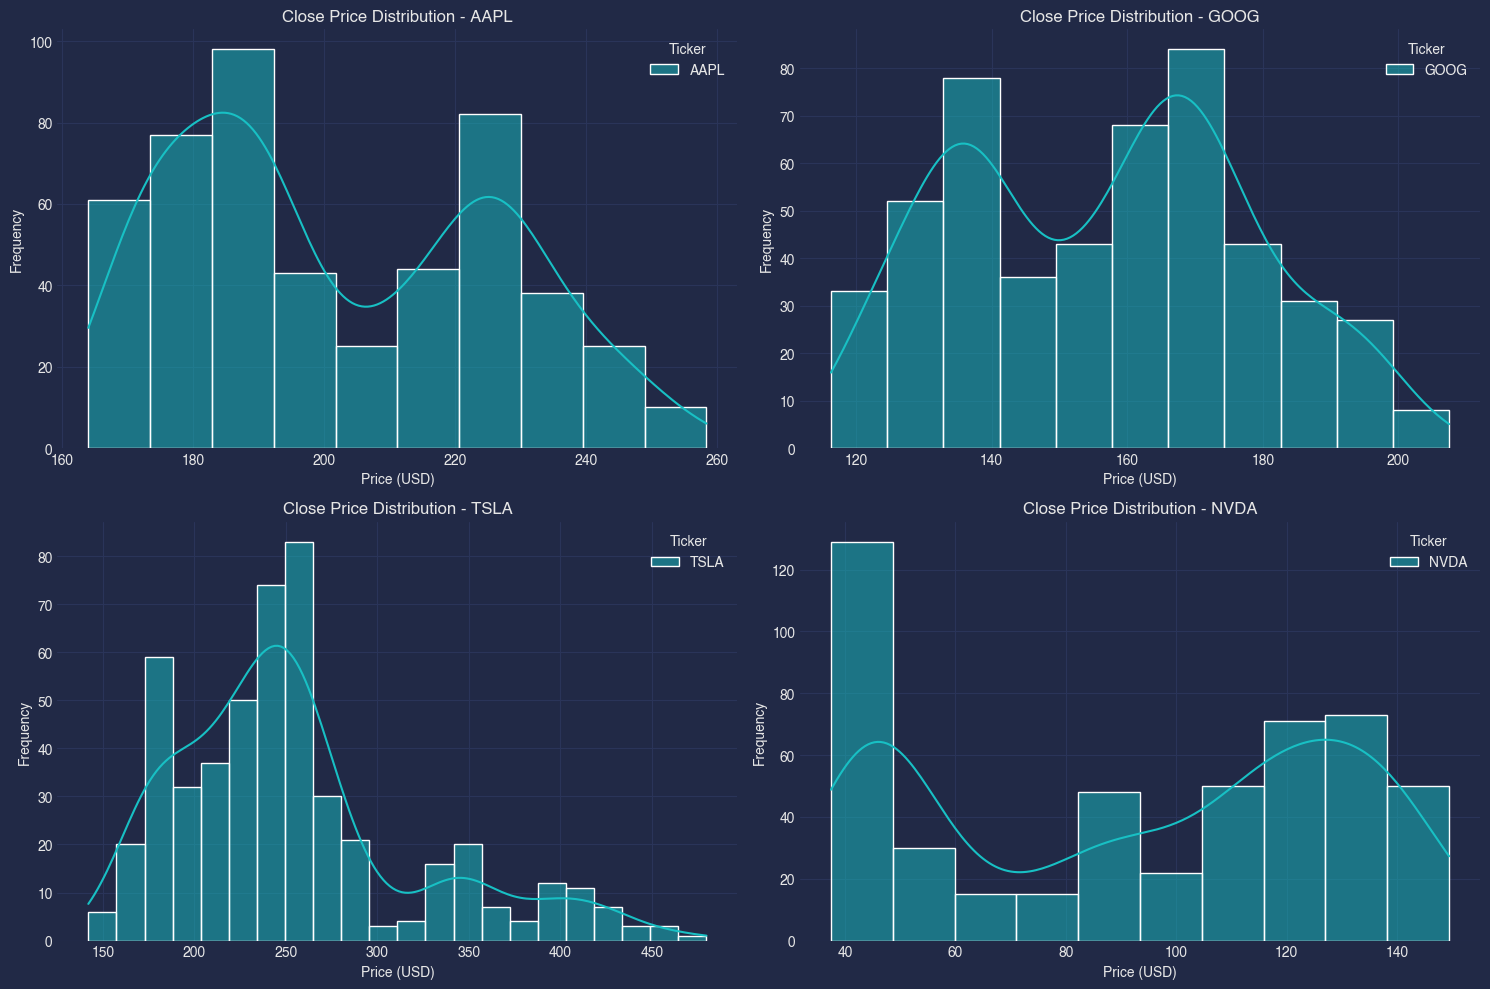

In [6]:
# Plot price distributions
plt.figure(figsize=(15, 10))
for i, (symbol, data) in enumerate(stock_data.items(), 1):
    plt.subplot(2, 2, i)
    sns.histplot(data['Close'], kde=True, color='skyblue')
    plt.title(f'Close Price Distribution - {symbol}')
    plt.xlabel('Price (USD)')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

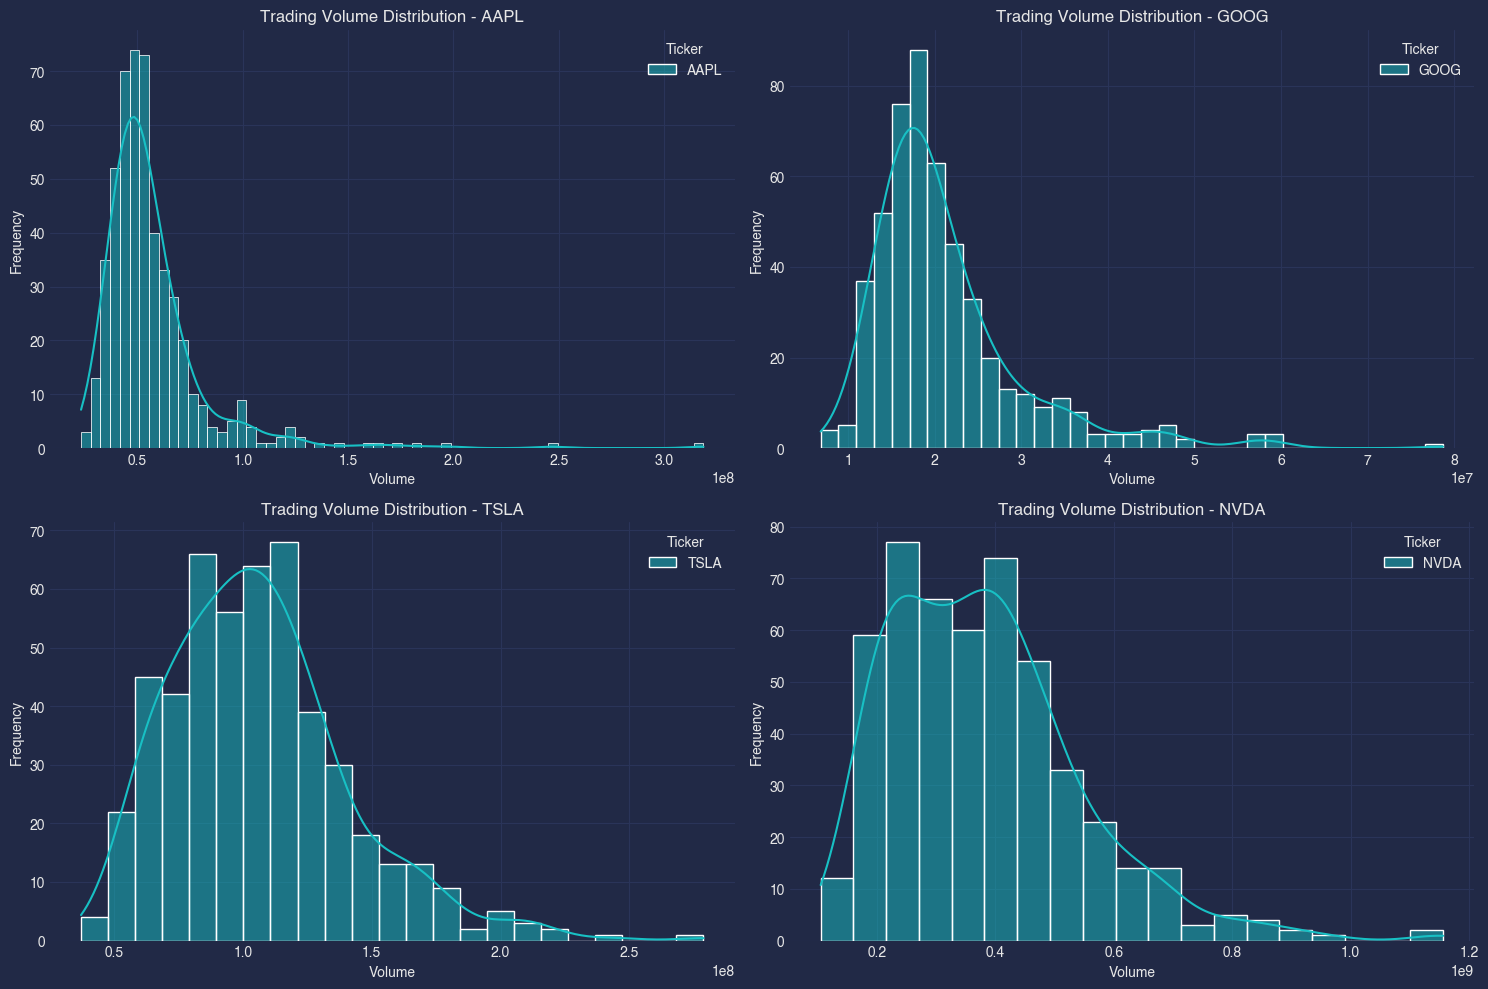

In [7]:
# Plot volume distributions
plt.figure(figsize=(15, 10))
for i, (symbol, data) in enumerate(stock_data.items(), 1):
    plt.subplot(2, 2, i)
    sns.histplot(data['Volume'], kde=True, color='salmon')
    plt.title(f'Trading Volume Distribution - {symbol}')
    plt.xlabel('Volume')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

## 3. Analyse des Corrélations

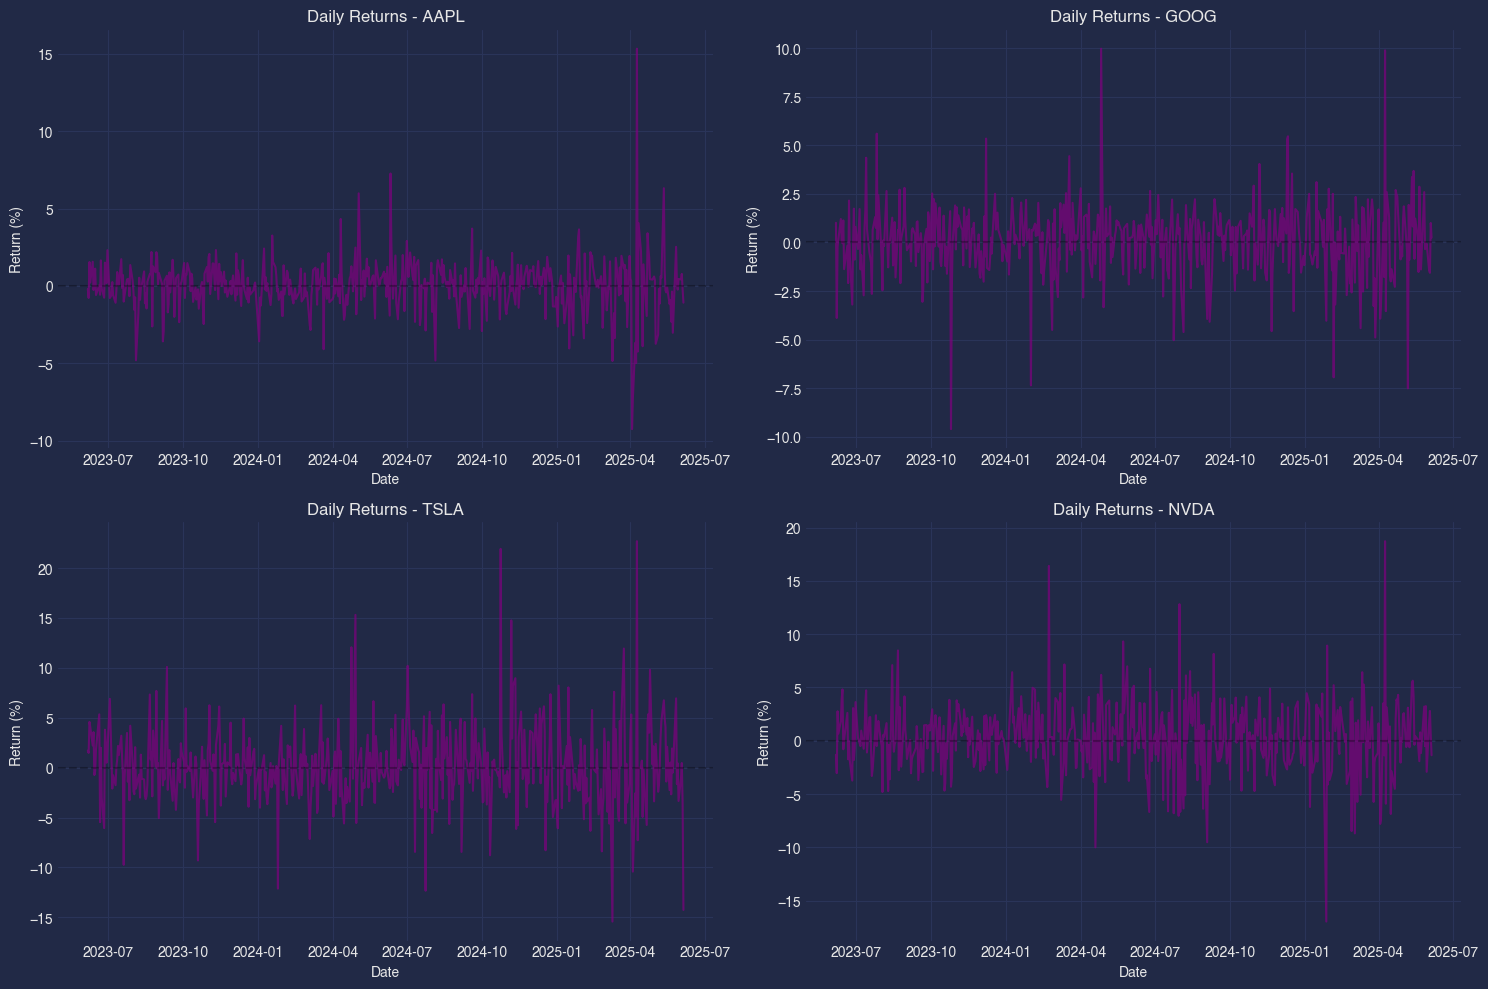

In [8]:
# Calculate correlation matrices
plt.figure(figsize=(15, 10))
for i, (symbol, data) in enumerate(stock_data.items(), 1):
    data['Daily Return'] = data['Close'].pct_change() * 100
    
    plt.subplot(2, 2, i)
    plt.plot(data['Date'], data['Daily Return'], color='purple', alpha=0.7)
    plt.axhline(0, color='black', linestyle='--', alpha=0.3)
    plt.title(f'Daily Returns - {symbol}')
    plt.xlabel('Date')
    plt.ylabel('Return (%)')
    plt.grid(True)
plt.tight_layout()
plt.show()


## 4. Analyse des Prix Historiques

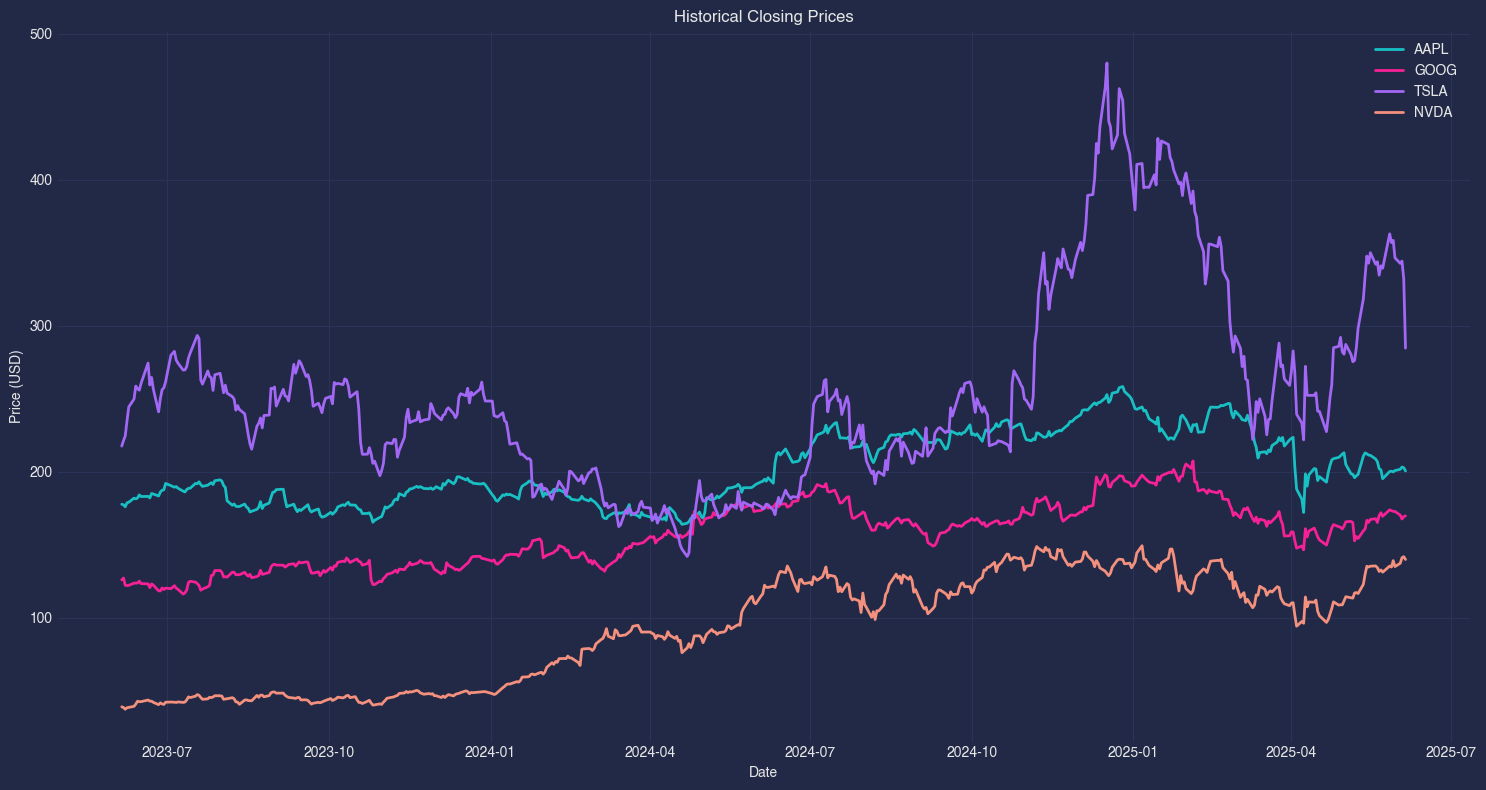

In [9]:
# Historical closing prices
plt.figure(figsize=(15, 8))
for symbol, data in stock_data.items():
    plt.plot(data['Date'], data['Close'], label=symbol, linewidth=2)
    
plt.title('Historical Closing Prices')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 5. Analyse du Volume des Transactions

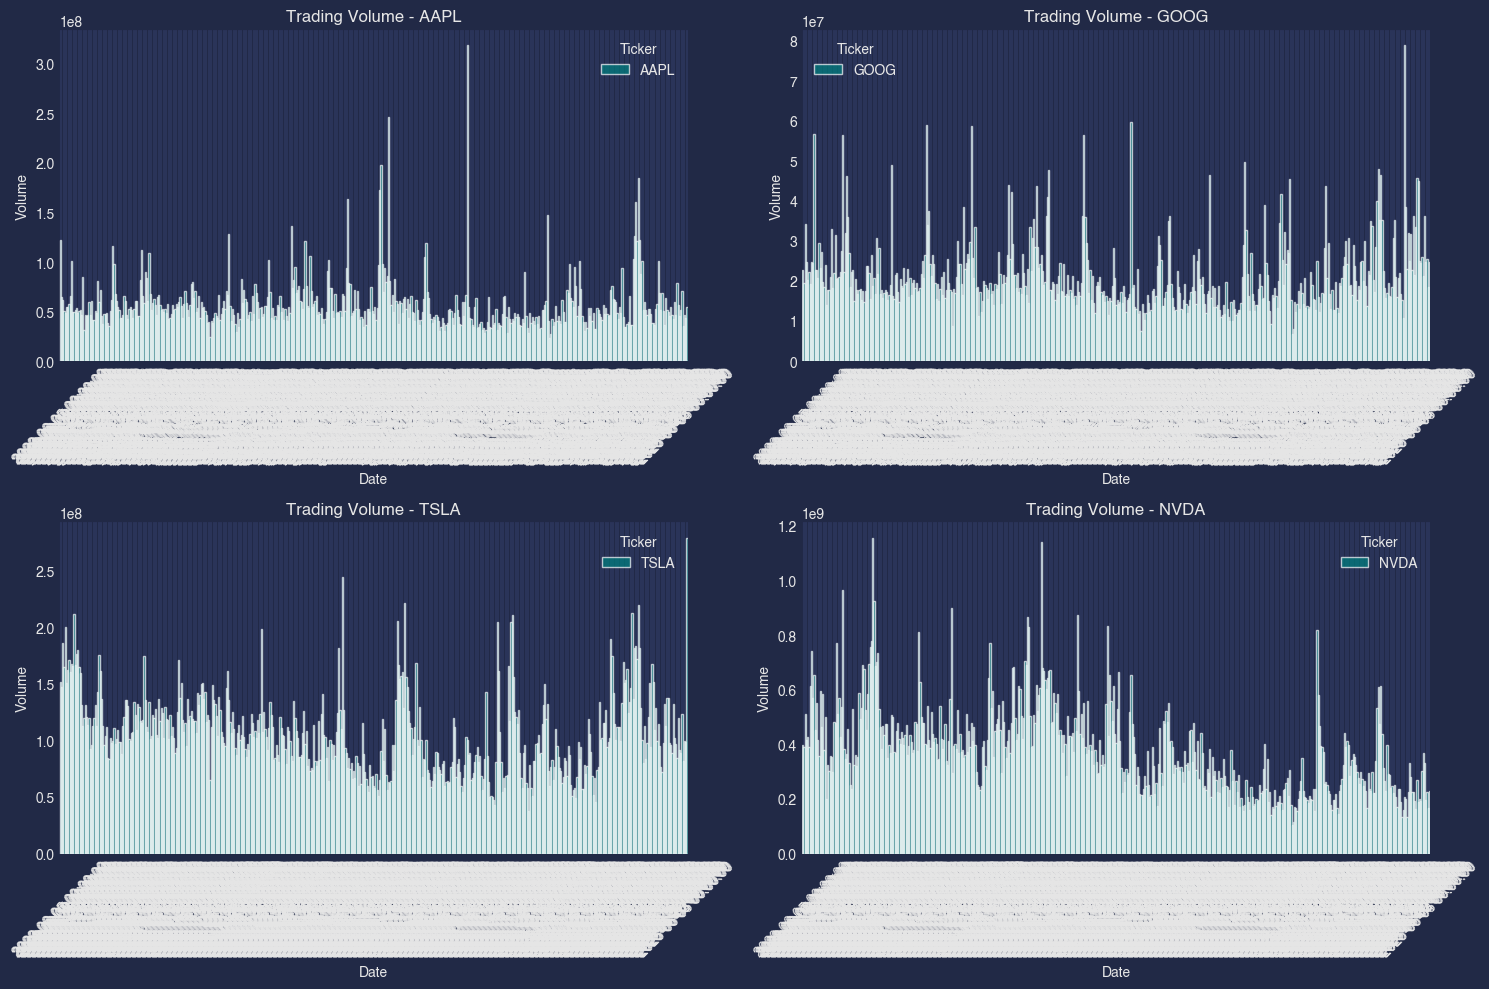

In [10]:
# Trading volume analysis (solution alternative)
plt.figure(figsize=(15, 10))
for i, (symbol, data) in enumerate(stock_data.items(), 1):
    ax = plt.subplot(2, 2, i)
    
    # Utiliser pandas pour tracer directement
    data.plot.bar(x='Date', y='Volume', ax=ax, color='teal', alpha=0.7, width=1)
    
    plt.title(f'Trading Volume - {symbol}')
    plt.xlabel('Date')
    plt.ylabel('Volume')
    plt.xticks(rotation=45)  # Rotation des étiquettes
    plt.grid(axis='y')
    
plt.tight_layout()
plt.show()

## 6. Volatilité (Écart-Type Mobile)

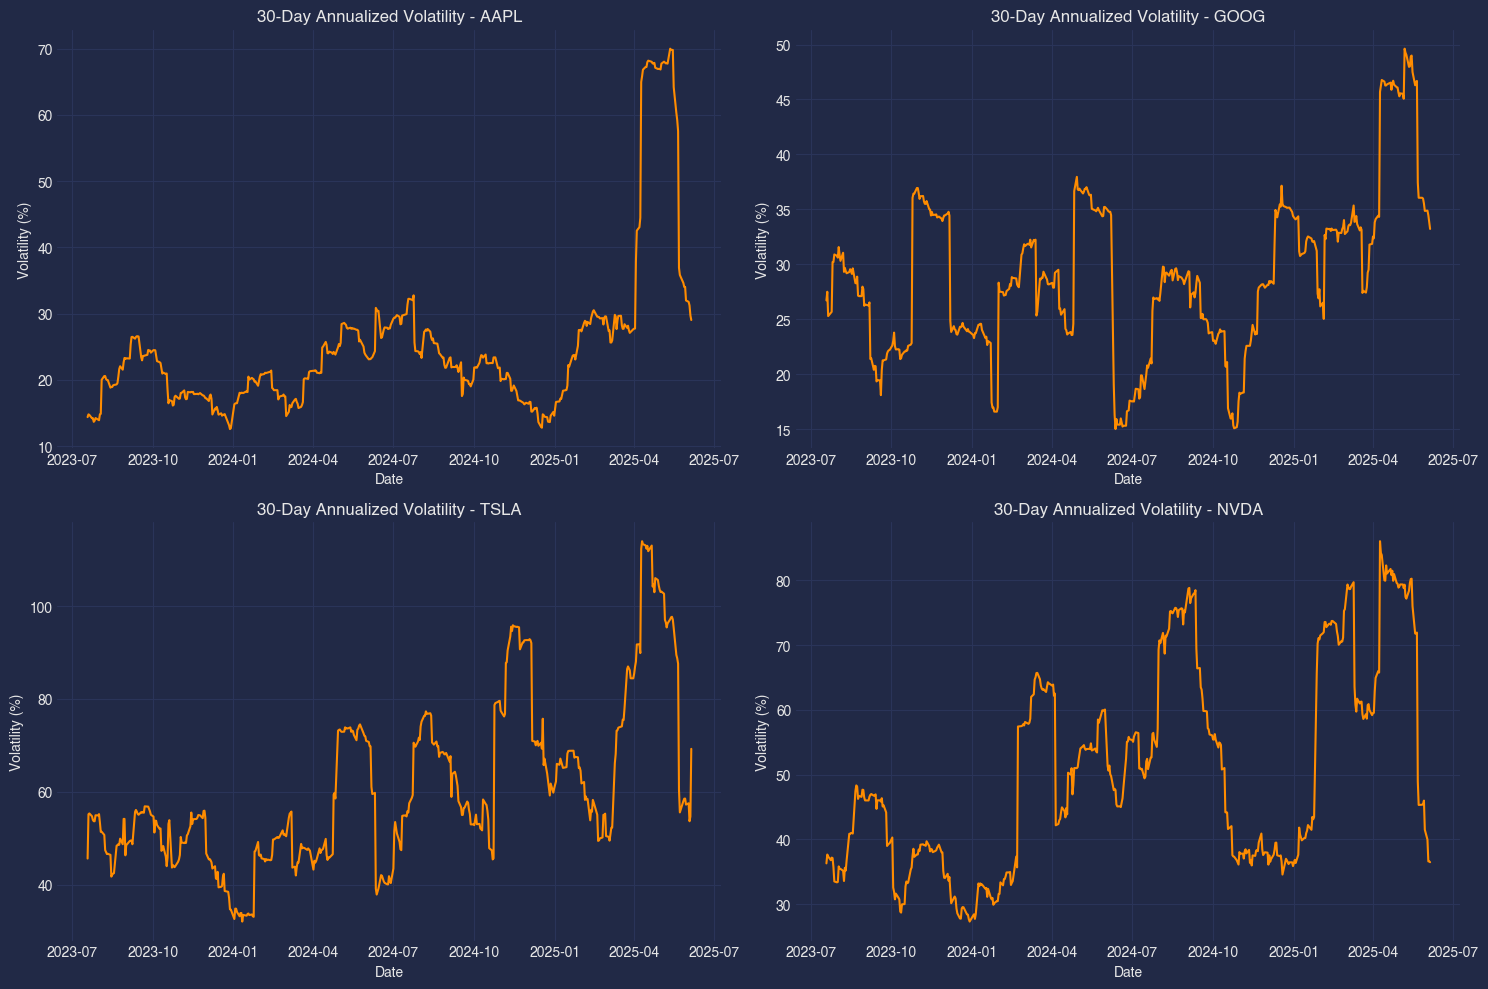

In [11]:
# Volatility analysis
plt.figure(figsize=(15, 10))
for i, (symbol, data) in enumerate(stock_data.items(), 1):
    data['Volatility'] = data['Close'].pct_change().rolling(window=30).std() * np.sqrt(252) * 100
    
    plt.subplot(2, 2, i)
    plt.plot(data['Date'], data['Volatility'], color='darkorange', linewidth=1.5)
    plt.title(f'30-Day Annualized Volatility - {symbol}')
    plt.xlabel('Date')
    plt.ylabel('Volatility (%)')
    plt.grid(True)
plt.tight_layout()
plt.show()

# Time Series Visualization

**What Is Time Series Data ?**

<p>&nbsp;</p>
A time series data is a series of data points listed in consecutive time order or we can say time series data is a sequence of successive equal interval points in time. A time-series analysis consists of methods for analyzing time-series data in order to extract meaningful insights and other valuable characteristics of data. 
<p>&nbsp;</p>
Time-series data analysis is becoming very important in so many industries like financial industries, pharmaceuticals, social media companies, web service providers, research, and many more. To understand the time-series data , Visualization of the data is essential. In fact, any type of data analysis is not complete without visualizations. Because one good visualization can provide meaningful and interesting insights into data.

<p>&nbsp;</p>

**Trend In The Dataset**

>We can see the change in trend in our dataset, Trend helps us see where the value of data that we are considering is going upward or downward in the long run.

<p>&nbsp;</p>

Source: [geeksforgeeks](https://www.geeksforgeeks.org/time-series-data-visualization-in-python/)

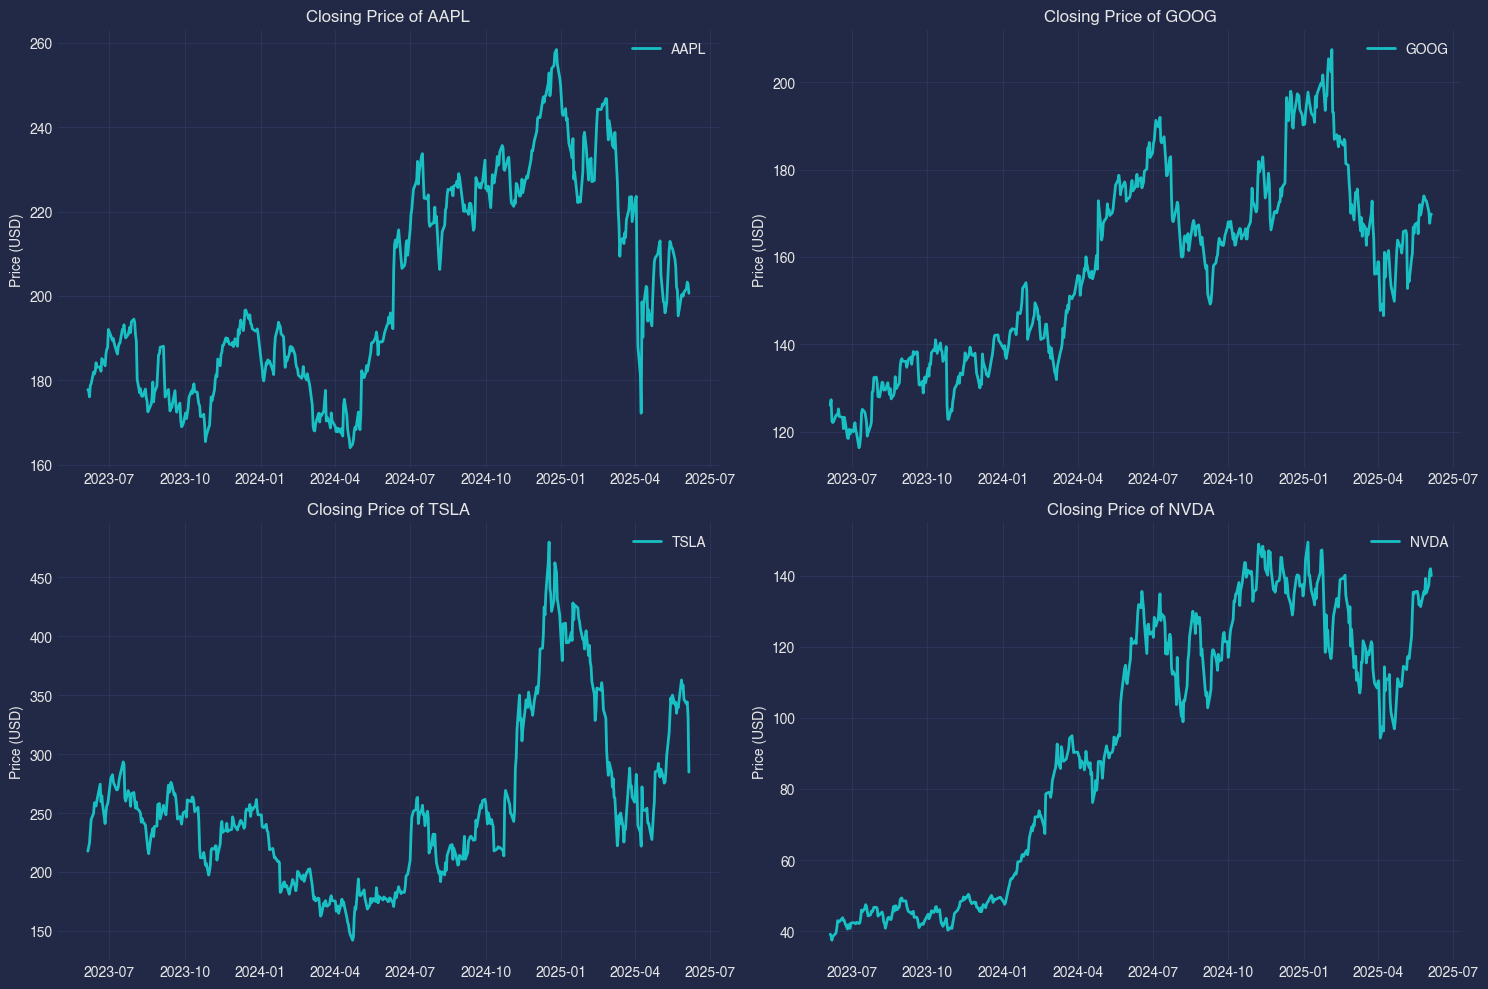

In [12]:
# Let's see a historical view of the closing price

# Let's see a historical view of the closing price
plt.figure(figsize=(15, 10))
for i, (symbol, data) in enumerate(stock_data.items(), 1):
    plt.subplot(2, 2, i)
    plt.plot(data['Date'], data['Close'], label=symbol, linewidth=2)
    plt.title(f"Closing Price of {symbol}")
    plt.ylabel("Price (USD)")
    plt.legend()
    plt.grid(True)
plt.tight_layout()


**why weekly charts?** 🤔
>The choice between weekly and daily charts is determined by your trading style and goals. Weekly charts provide a more broad view of price trends, making them appropriate for long-term traders and institutiional analysts. Combining weekly and daily charts can confirm trends and signals while also providing a thorough analysis. Weekly charts suit less active traders looking for long-term trend changes or downtrend signals. Finally , the decision is based on your preferences and the level of detail required for successful trading.

In [13]:
for symbol, data in stock_data.items():
    print(f"\nColonnes disponibles pour {symbol}:")
    print(data.columns.tolist())


Colonnes disponibles pour AAPL:
[('Date', ''), ('Close', 'AAPL'), ('High', 'AAPL'), ('Low', 'AAPL'), ('Open', 'AAPL'), ('Volume', 'AAPL'), ('Symbol', ''), ('Daily Return', ''), ('Volatility', '')]

Colonnes disponibles pour GOOG:
[('Date', ''), ('Close', 'GOOG'), ('High', 'GOOG'), ('Low', 'GOOG'), ('Open', 'GOOG'), ('Volume', 'GOOG'), ('Symbol', ''), ('Daily Return', ''), ('Volatility', '')]

Colonnes disponibles pour TSLA:
[('Date', ''), ('Close', 'TSLA'), ('High', 'TSLA'), ('Low', 'TSLA'), ('Open', 'TSLA'), ('Volume', 'TSLA'), ('Symbol', ''), ('Daily Return', ''), ('Volatility', '')]

Colonnes disponibles pour NVDA:
[('Date', ''), ('Close', 'NVDA'), ('High', 'NVDA'), ('Low', 'NVDA'), ('Open', 'NVDA'), ('Volume', 'NVDA'), ('Symbol', ''), ('Daily Return', ''), ('Volatility', '')]


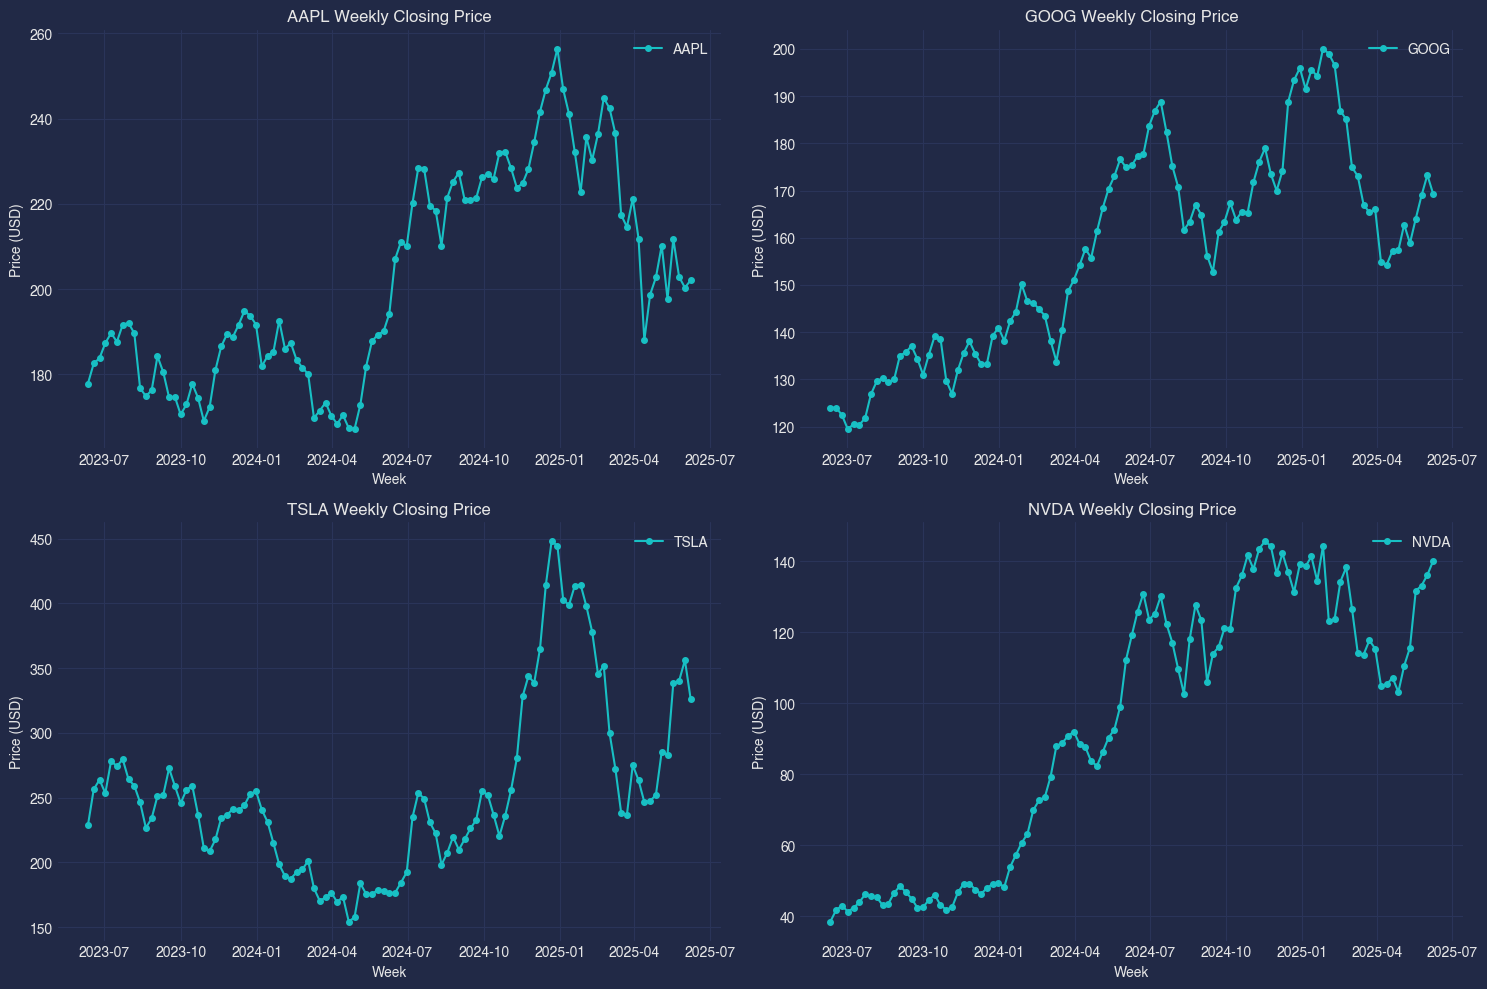

In [14]:
# 1. Rename the columns in each DataFrame
for symbol, data in stock_data.items():
    data.columns = [col[0] for col in data.columns]  # Prendre seulement la 1ère partie du tuple

# Plotting the closing prices for each week
plt.figure(figsize=(15, 10))
for i, (symbol, data) in enumerate(stock_data.items(), 1):
    plt.subplot(2, 2, i)
    
    # Convert to datetime if necessary (safety)
    data['Date'] = pd.to_datetime(data['Date'])
    
    weekly = data.resample('W', on='Date').agg({'Close': 'mean'}).reset_index()
    plt.plot(weekly['Date'], weekly['Close'], label=symbol, marker='o', linestyle='-', markersize=4)
    plt.title(f"{symbol} Weekly Closing Price")
    plt.xlabel("Week")
    plt.ylabel("Price (USD)")
    plt.legend()
    plt.grid(True)
plt.tight_layout()
plt.show()

### Candlestick Charts

Candlestick graphs/charts provide a visual representation of price fluctuations, aiding traders in pattern identification and predicting short-term price trends. Each candle, representing a time period, consists of a body, upper shadow, and lower shadow.

<img src="https://wp-asset.groww.in/wp-content/uploads/2020/10/17103706/candle.jpg">



The body, colored red or green, indicates the opening and closing prices during the specified period. Understanding the body's color helps traders discern rising or falling stock prices. The candle also has four data points: Open, High, Low, Close (OHLC).

1. **Open:** The opening price at the beginning of the time period represented by the candle.

2. **High:** The highest price reached during the specified time period.

3. **Low:** The lowest price observed during the same time frame.

4. **Close:** The closing price at the end of the time period.

<img src="https://wp-asset.groww.in/wp-content/uploads/2020/10/17115223/can.jpg">


Analyzing a candlestick chart involves interpreting the body size, color, and the presence of wicks or shadows above and below. Short upper wicks on red candles suggest a near-high opening, while short upper wicks on green candles indicate a near-high closing.
<p>&nbsp;</p>

> *Utilizing this information, traders can grasp the market sentiment toward a stock. For further insights, refer to [groww](https://groww.in/blog/how-to-read-candlestick-charts).*

In [15]:
# Plotting Candlestick chart for each stock
for symbol, data in stock_data.items():
    fig = go.Figure(data=[go.Candlestick(
        x=data["Date"],
        open=data['Open'],
        high=data['High'],
        low=data['Low'],
        close=data['Close']
    )])
    
    fig.update_layout(
        title=f'{symbol} Stock Price Candlestick Chart',
        xaxis_title='Date',
        yaxis_title='Stock Price (USD)',
        template='plotly_dark'
    )
    fig.show()

### Technical Analysis and Performance Metric

### Moving Averages

**What Is a Moving Average (MA)?**
>In finance, a moving average (MA) is a widely used stock indicator in technical analysis, aimed at smoothing out price data by calculating a constantly updated average. The choice of the moving average period determines the level of lag , with longer periods having greater lag. Investors and traders often follow the 50-day and 200-day moving averages as significant trading signals.

**Why Use a Moving Average?**
>The primary purpose of a moving average is to reduce noise on a price chart and provide insights into the overall price direction. An upward angle indicates an overall upward price movement, while a downward angle suggests a downward trend. Additionally, moving averages can serve as support or resistance levels. In an uptrend, they may act as support, preventing prices from falling below. Conversely, in a downtrend, moving averages can act as resistance, limiting upward movements.



<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana;">
    📌 Moving average lengths of 10, 20, 50, 100, and 200 are common. Depending on the trader's time horizon, these lengths can be applied to any chart time frame (one minute, daily, weekly, and so on).

</div>

<p>&nbsp;</p>

Source: [investopedia](https://www.investopedia.com/terms/m/movingaverage.asp)

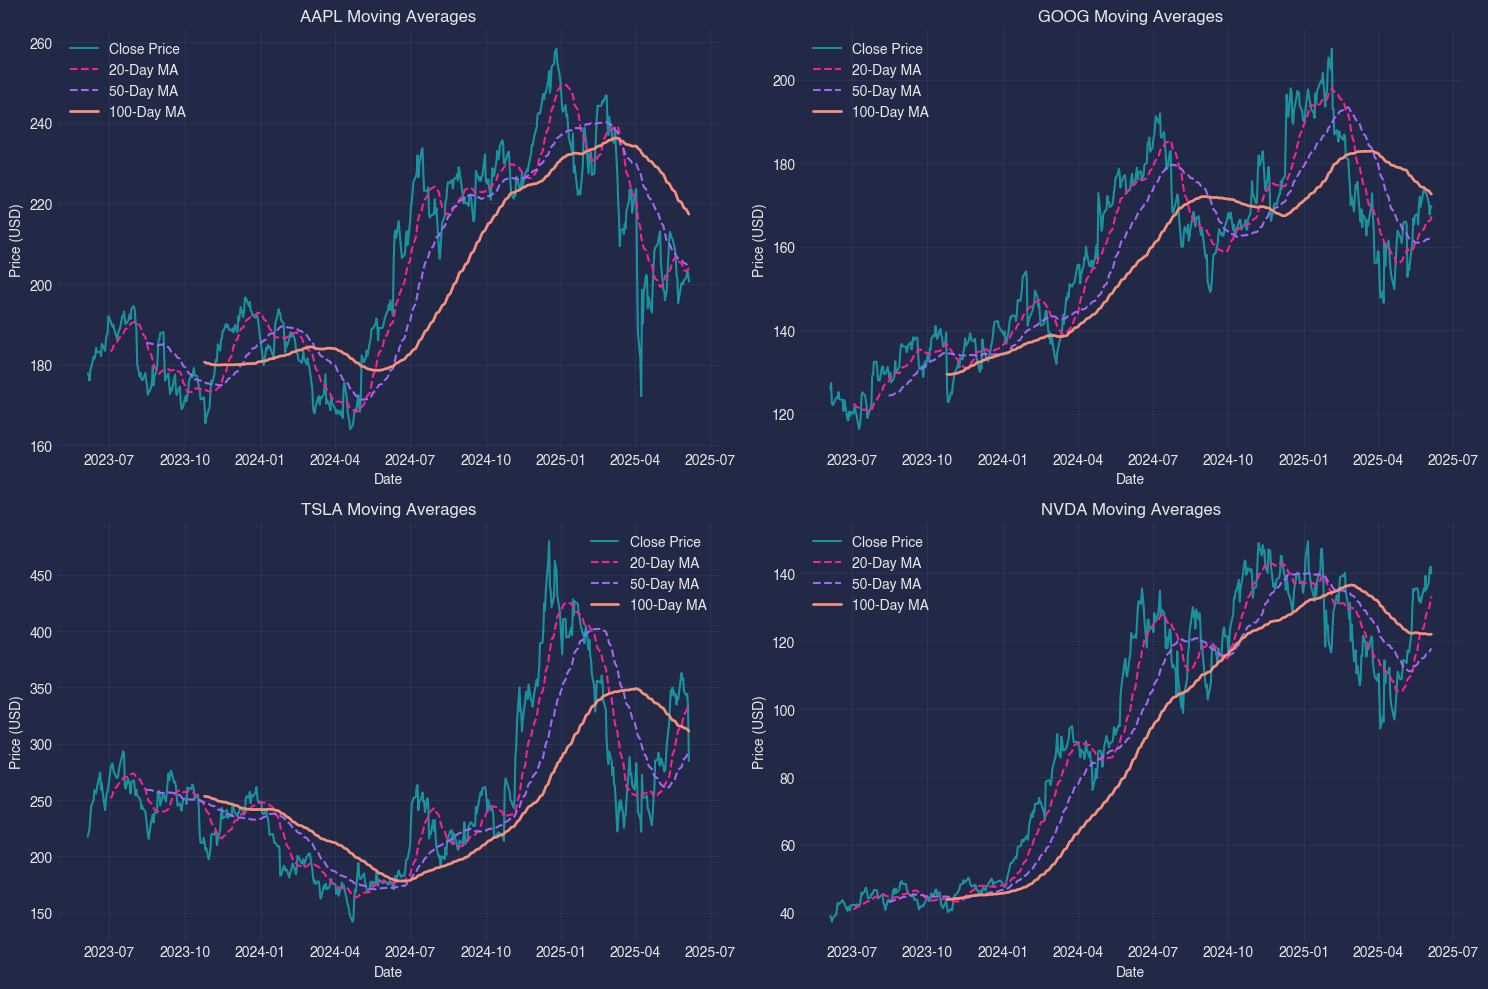

In [16]:
# calculating and plotting MA for each stock
plt.figure(figsize=(15, 10))
for i, (symbol, data) in enumerate(stock_data.items(), 1):
    plt.subplot(2, 2, i)
    # Calculate moving averages
    data['MA_20'] = data['Close'].rolling(window=20).mean()
    data['MA_50'] = data['Close'].rolling(window=50).mean()
    data['MA_100'] = data['Close'].rolling(window=100).mean()

    # Plot all lines
    plt.plot(data['Date'], data['Close'], label='Close Price', alpha=0.7)
    plt.plot(data['Date'], data['MA_20'], label='20-Day MA', linestyle='--', linewidth=1.5)
    plt.plot(data['Date'], data['MA_50'], label='50-Day MA', linestyle='--', linewidth=1.5)
    plt.plot(data['Date'], data['MA_100'], label='100-Day MA', linestyle='-', linewidth=2)
    
    plt.title(f"{symbol} Moving Averages")
    plt.xlabel("Date")
    plt.ylabel("Price (USD)")
    plt.legend()
    plt.grid(True)
plt.tight_layout()
plt.show()

In [17]:
# Moving Averages Visualization with Plotly
for symbol, data in stock_data.items():
    # Calculate moving averages
    data['MA50'] = data['Close'].rolling(window=50).mean()
    data['MA200'] = data['Close'].rolling(window=200).mean()
    
    # Create a Plotly line plot
    fig = px.line(
        data, 
        x='Date', 
        y=['Close', 'MA50', 'MA200'], 
        title=f'{symbol} Stock Price with Moving Averages',
        labels={'value': 'Price (USD)', 'variable': 'Metric'},
        color_discrete_sequence=['#1f77b4', '#ff7f0e', '#d62728']  # Blue, Orange, Red
    )
    
    # Update layout
    fig.update_layout(
        template='plotly_dark',
        xaxis_title='Date',
        yaxis_title='Price (USD)',
        legend_title='Metrics',
        hovermode='x unified',
        height=600
    )
    
    # Customize lines
    fig.for_each_trace(lambda t: t.update(line=dict(width=2)) if t.name == 'Close' else t.update(line=dict(width=1.5, dash='dash')))
    
    # Add annotations for moving averages
    fig.add_annotation(
        xref='paper', x=0.05, yref='paper', y=0.95,
        text=f"50-Day MA: Technical indicator showing average price over 50 days",
        showarrow=False,
        font=dict(size=12, color='#ff7f0e')
    )
    
    fig.add_annotation(
        xref='paper', x=0.05, yref='paper', y=0.90,
        text=f"200-Day MA: Long-term trend indicator",
        showarrow=False,
        font=dict(size=12, color='#d62728')
    )
    
    # Show the figure
    fig.show()

## RSI (Relative Strength Index)

* The Relative Strength Index (RSI) is a momentum indicator used in technical analysis to determine whether a security is overvalued or undervalued based on recent price changes. 
<p>&nbsp;</p>
* The RSI indicator helps traders in identifying bullish or bearish momentum signals. 
<p>&nbsp;</p>
* It is shown as a line beneath the price graph of the asset, with readings above 70 indicating <span style="color:crimson;">overbought</span> conditions and readings below 30 indicating <span style="color:crimson;">oversold</span>  conditions.
<p>&nbsp;</p>
* RSI crossovers with these thresholds are often considered by traders as potential buy or sell signals. The RSI works more effectively in trading ranges than in trending markets.

<p>&nbsp;</p>

Source: [investopedia](https://www.investopedia.com/terms/r/rsi.asp)

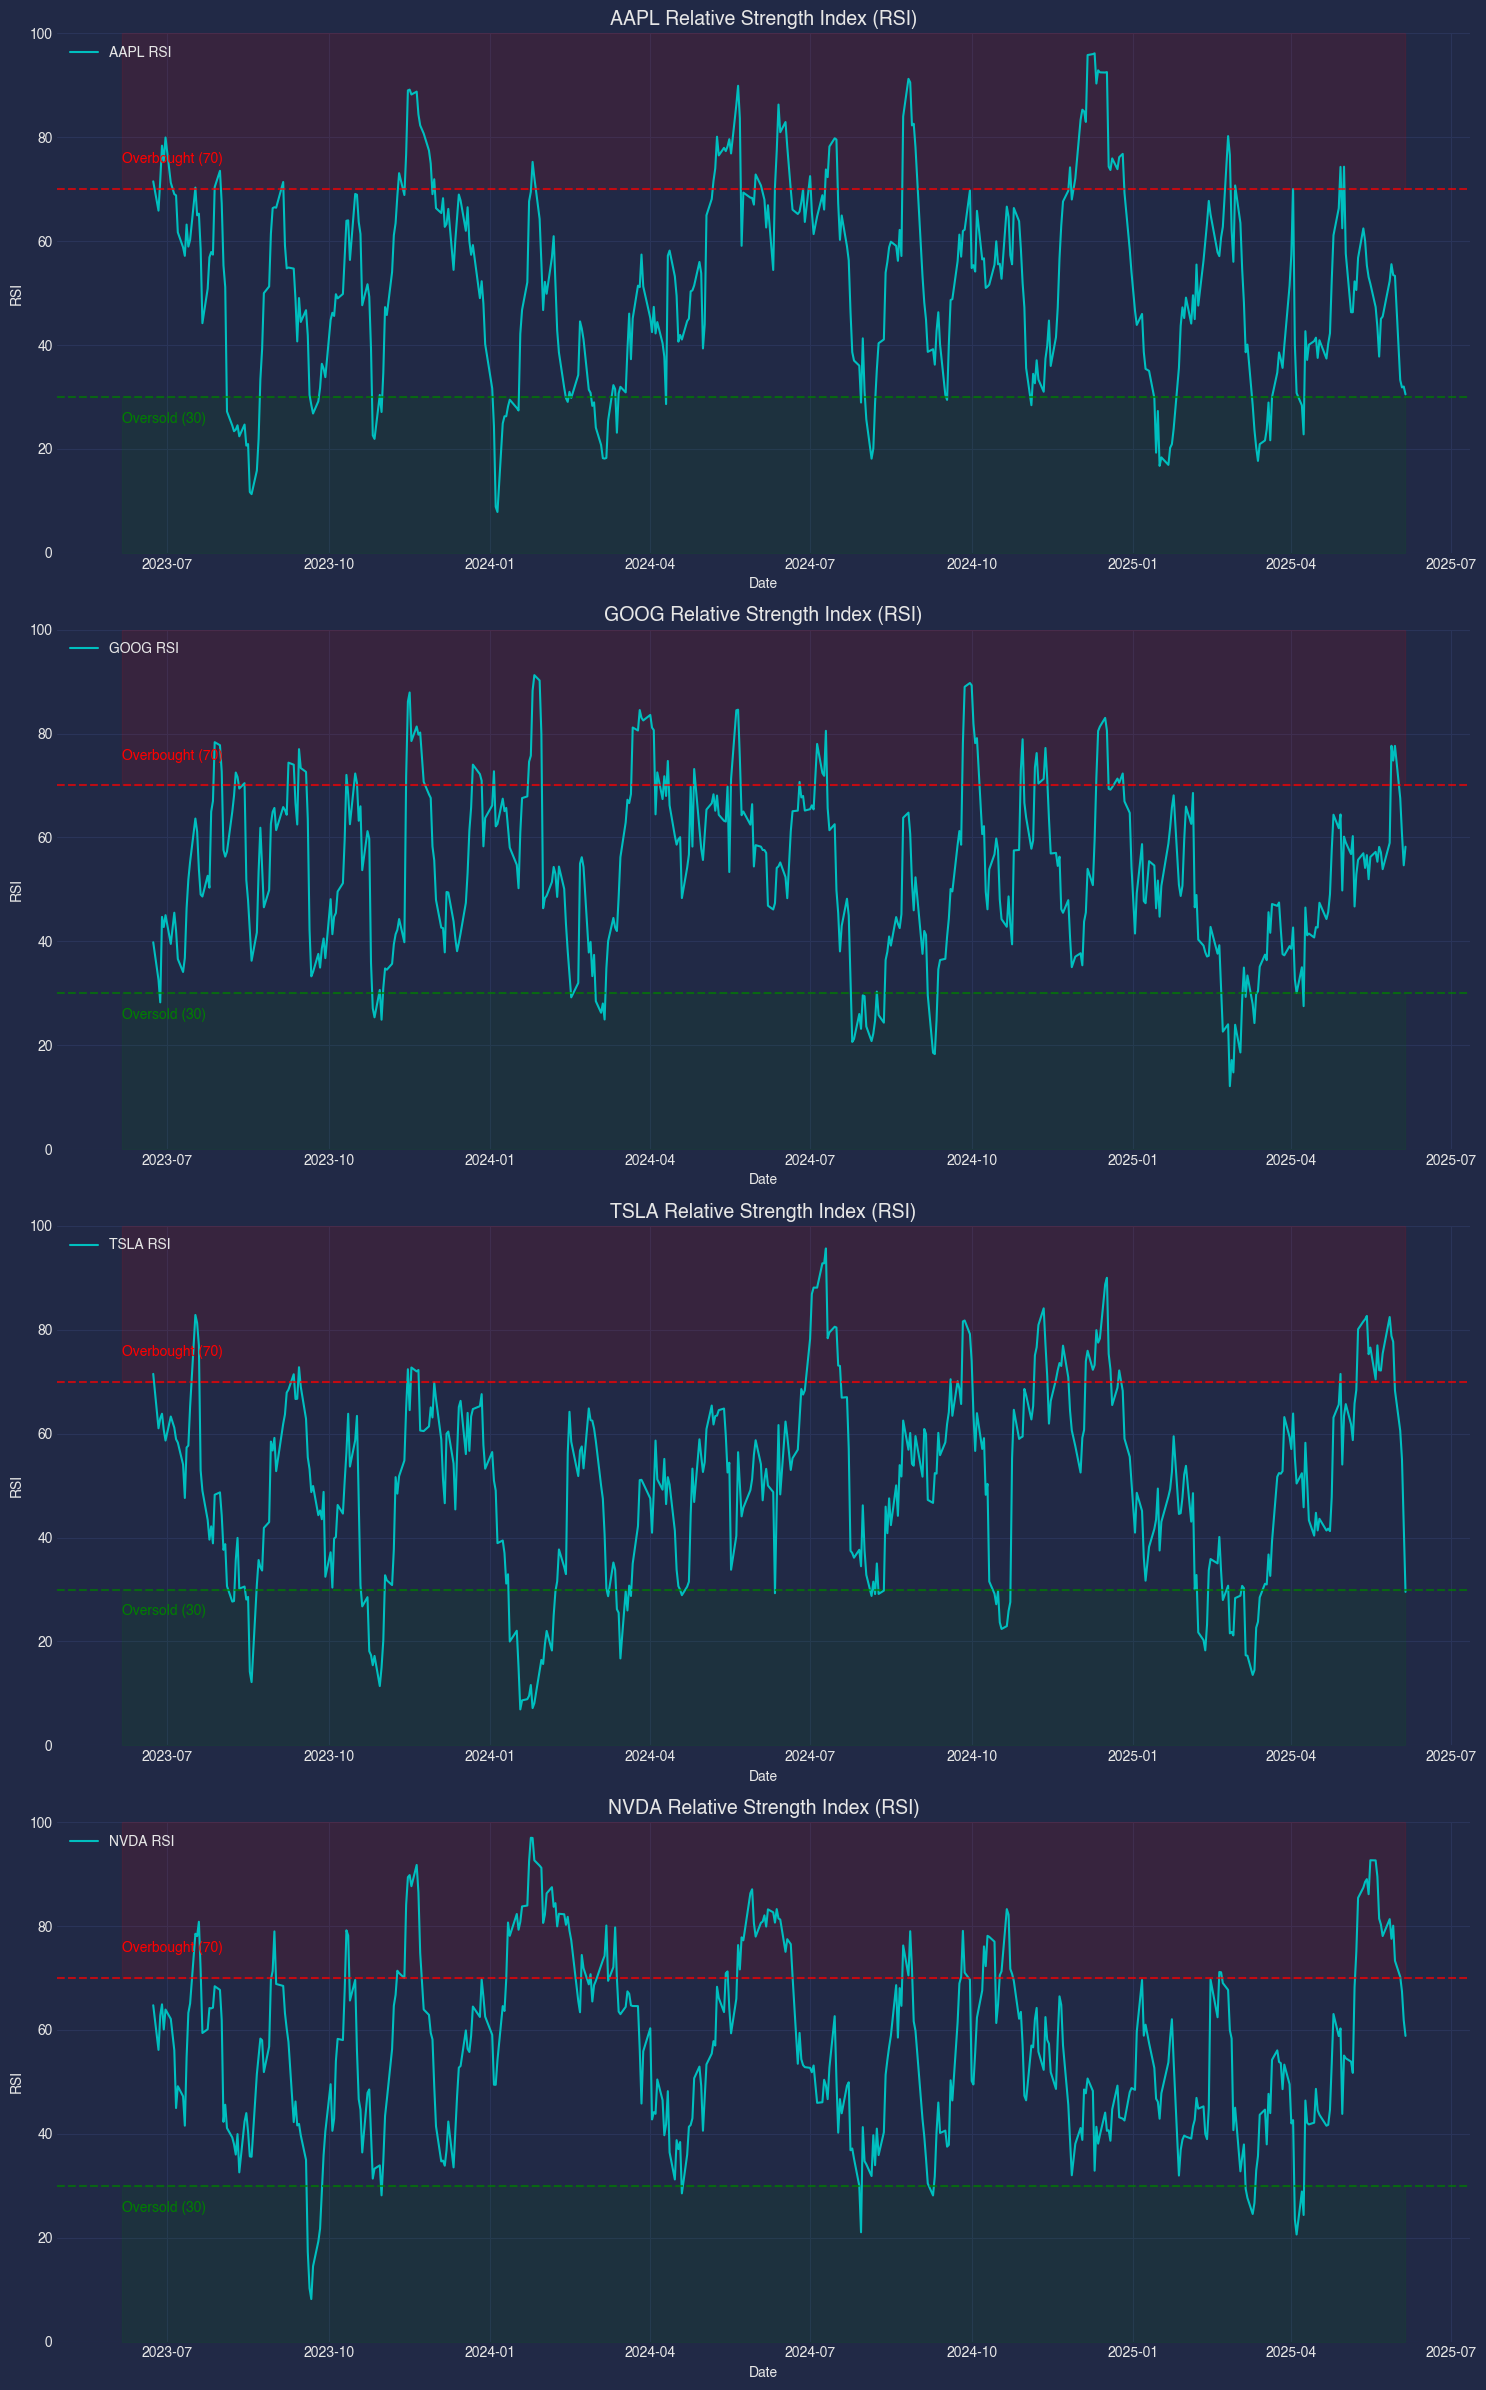

In [18]:
# RSI (Relative Strength Index)
# calculating and plotting RSI for each stock
plt.figure(figsize=(15, 24))
plt.subplots_adjust(top=1.25, bottom=1.2, hspace=0.5)

for i, (symbol, data) in enumerate(stock_data.items(), 1):
    ax = plt.subplot(4, 1, i)
    
    # Calculate daily price change
    data['Daily Change'] = data['Close'].diff()

    # the lookback period for RSI
    period = 14  # a lookback period of 14 is a common choice for calculating the RSI

    # Calculate gains and losses
    data['Gain'] = data['Daily Change'].apply(lambda x: x if x > 0 else 0)
    data['Loss'] = data['Daily Change'].apply(lambda x: -x if x < 0 else 0)
    
    # Calculate average gains and losses
    data['Avg Gain'] = data['Gain'].rolling(window=period).mean()
    data['Avg Loss'] = data['Loss'].rolling(window=period).mean()
    
    # Calculate relative strength (RS)
    data['RS'] = data['Avg Gain'] / data['Avg Loss']
    
    # Calculate RSI
    data['RSI'] = 100 - (100 / (1 + data['RS']))
    
    # Plotting the RSI
    plt.plot(data['Date'], data['RSI'], label=f'{symbol} RSI', color='c', linewidth=1.5)
    plt.axhline(y=70, color='r', linestyle='--', alpha=0.7)
    plt.axhline(y=30, color='g', linestyle='--', alpha=0.7)
    
    # Fill between overbought and oversold levels
    plt.fill_between(data['Date'], 70, 100, color='red', alpha=0.1)
    plt.fill_between(data['Date'], 0, 30, color='green', alpha=0.1)
    
    plt.title(f'{symbol} Relative Strength Index (RSI)', fontsize=14)
    plt.xlabel('Date')
    plt.ylabel('RSI')
    plt.ylim(0, 100)
    plt.grid(True)
    
    # Add legend
    plt.legend(loc='upper left')
    
    # Add text annotations
    plt.text(data['Date'].iloc[0], 75, 'Overbought (70)', color='r', fontsize=10)
    plt.text(data['Date'].iloc[0], 25, 'Oversold (30)', color='g', fontsize=10)

plt.tight_layout()
plt.show()

In [19]:
# Interactive RSI with Plotly

from plotly.subplots import make_subplots

# Create subplots
fig = make_subplots(
    rows=4, cols=1,
    subplot_titles=[f'{symbol} RSI' for symbol in stock_symbols],
    vertical_spacing=0.05,
    shared_xaxes=True
)

for i, (symbol, data) in enumerate(stock_data.items(), 1):
    # Calculate RSI (same as above)
    data['Daily Change'] = data['Close'].diff()
    period = 14
    data['Gain'] = data['Daily Change'].apply(lambda x: x if x > 0 else 0)
    data['Loss'] = data['Daily Change'].apply(lambda x: -x if x < 0 else 0)
    data['Avg Gain'] = data['Gain'].rolling(window=period).mean()
    data['Avg Loss'] = data['Loss'].rolling(window=period).mean()
    data['RS'] = data['Avg Gain'] / data['Avg Loss']
    data['RSI'] = 100 - (100 / (1 + data['RS']))
    
    # Add RSI trace
    fig.add_trace(
        go.Scatter(
            x=data['Date'], 
            y=data['RSI'],
            name=f'{symbol} RSI',
            line=dict(color='cyan', width=1.5),
            showlegend=True
        ),
        row=i, col=1
    )
    
    # Add horizontal lines
    fig.add_hline(y=70, line_dash="dash", line_color="red", row=i, col=1)
    fig.add_hline(y=30, line_dash="dash", line_color="green", row=i, col=1)
    
    # Add shaded regions
    fig.add_hrect(
        y0=70, y1=100, 
        fillcolor="red", opacity=0.1, 
        line_width=0, row=i, col=1
    )
    fig.add_hrect(
        y0=0, y1=30, 
        fillcolor="green", opacity=0.1, 
        line_width=0, row=i, col=1
    )

# Update layout
fig.update_layout(
    title_text='Relative Strength Index (RSI)',
    height=1000,
    template='plotly_dark',
    hovermode='x unified',
    yaxis_title='RSI'
)

# Update y-axes range
for i in range(1, 5):
    fig.update_yaxes(range=[0, 100], row=i, col=1)

fig.show()

## Volatility Analysis

**What is Volatility and How is it Useful in Finance?📚**
<p>&nbsp;</p>
Volatility, which is a measure of price fluctuation, indicates how much a stock or market index can change. Higher volatility implies greater risk, as prices may experience significant swings. This uncertainty has an impact on option prices. on the other hand, lower volatility signals more stable prices.
<p>&nbsp;</p>
The percentage of daily returns measures asset variation, with historical volatility reflecting past price fluctuations expressed as a percentage over daily, weekly, monthly , or yearly time periods. It is calculated by multiplying the standard deviation by the square root of the number of time periods.
<p>&nbsp;</p>

vol = σ√T

where:

* v = volatility over some interval of time

* σ = standard deviation of returns

* T = number of periods in the time horizon

<p>&nbsp;</p>
While volatility is often associated with risk, they are not synonymous.Volatility measures the speed and magnitude of price movements, whereas risk refers to potential losses. The impact of volatility depends on your trading style and risk tolerance.  High volatility can be difficult for long-term investors, but it can also provide opportunities for day and options traders. High volatility suggests rapid and substantial price shifts.

> *This summary is based on my understanding, and for more in-depth insights, you can explore the details on [investopedia](https://www.investopedia.com/terms/v/volatility.asp#toc-example-of-volatility) .*



>📌 The code computes the percentage change in closing prices and then applies a rolling window to calculate the standard deviation. The window size of 20 indicates that it considers the last 20 periods to compute the standard deviation, providing a measure of short-term volatility.

In [20]:
# Volatility Analysis with Plotly
from plotly.subplots import make_subplots

# Create subplots
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=[f'20-Day Volatility - {symbol}' for symbol in stock_symbols],
    vertical_spacing=0.1,
    horizontal_spacing=0.1
)

for i, (symbol, data) in enumerate(stock_data.items(), 1):
    # Calculate volatility
    data['Daily Return'] = data['Close'].pct_change()
    data['Volatility'] = data['Daily Return'].rolling(window=20).std() * 100
    
    # Calculate mean volatility
    mean_vol = data['Volatility'].mean()
    high_vol_threshold = mean_vol * 1.5
    
    # Get row and column position
    row = (i-1)//2 + 1
    col = (i-1)%2 + 1
    
    # Add volatility trace
    fig.add_trace(
        go.Scatter(
            x=data['Date'], 
            y=data['Volatility'],
            name='Volatility',
            line=dict(color='purple', width=2),
            showlegend=(i==1)
        ),
        row=row, col=col
    )
    
    # Add mean volatility line
    fig.add_hline(
        y=mean_vol, 
        line_dash="dash", 
        line_color="blue",
        annotation_text=f"Mean: {mean_vol:.2f}%", 
        annotation_position="bottom right",
        row=row, col=col
    )
    
    # Add high volatility threshold
    fig.add_hline(
        y=high_vol_threshold, 
        line_dash="dot", 
        line_color="red",
        annotation_text=f"High Vol: {high_vol_threshold:.2f}%", 
        annotation_position="top right",
        row=row, col=col
    )
    
    # Add high volatility markers
    high_vol_periods = data[data['Volatility'] > high_vol_threshold]
    fig.add_trace(
        go.Scatter(
            x=high_vol_periods['Date'], 
            y=high_vol_periods['Volatility'],
            mode='markers',
            marker=dict(color='red', size=6),
            name='High Volatility',
            showlegend=(i==1)
        ),
        row=row, col=col
    )

# Update layout
fig.update_layout(
    title_text='Short-Term Volatility Analysis (20-Day Rolling)',
    height=800,
    template='plotly_dark',
    hovermode='x unified',
    yaxis_title='Volatility (%)'
)

# Update y-axes
for i in range(1, 5):
    fig.update_yaxes(title_text='Volatility (%)', row=(i-1)//2 + 1, col=(i-1)%2 + 1)

fig.show()

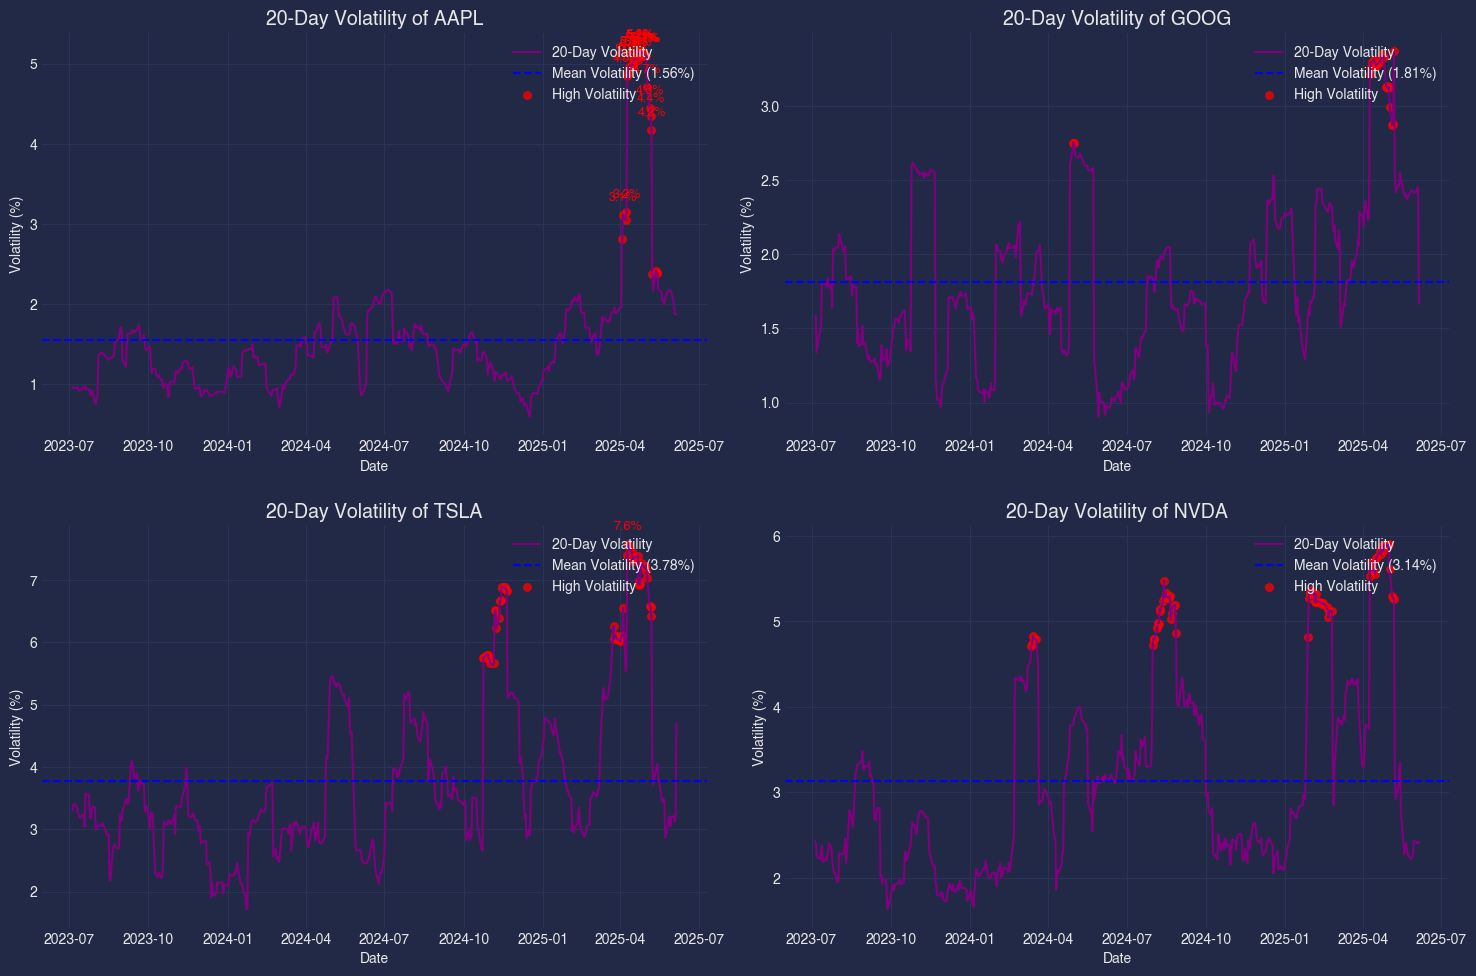

In [21]:
# Volatility Analysis - Short Term
plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=1.25, bottom=1.2, hspace=0.3)

for i, (symbol, data) in enumerate(stock_data.items(), 1):
    ax = plt.subplot(2, 2, i)
    
    # Calculate volatility (20-day rolling standard deviation of daily returns)
    data['Daily Return'] = data['Close'].pct_change()
    data['Volatility'] = data['Daily Return'].rolling(window=20).std() * 100  # In percentage
    
    # Plot volatility
    plt.plot(data['Date'], data['Volatility'], label='20-Day Volatility', color='purple', linewidth=1.5)
    
    # Add important levels
    mean_vol = data['Volatility'].mean()
    plt.axhline(y=mean_vol, color='b', linestyle='--', label=f'Mean Volatility ({mean_vol:.2f}%)')
    
    # Highlight high volatility periods
    high_vol_threshold = mean_vol * 1.5
    high_vol_periods = data[data['Volatility'] > high_vol_threshold]
    plt.scatter(high_vol_periods['Date'], high_vol_periods['Volatility'], 
                color='red', s=30, label='High Volatility', alpha=0.7)
    
    plt.title(f'20-Day Volatility of {symbol}', fontsize=14)
    plt.xlabel('Date')
    plt.ylabel('Volatility (%)')
    plt.grid(True)
    plt.legend(loc='upper right')
    
    # Add text annotation for volatility spikes
    for _, row in high_vol_periods.iterrows():
        if row['Volatility'] > mean_vol * 2:  # Only annotate significant spikes
            plt.annotate(f"{row['Volatility']:.1f}%", 
                         (row['Date'], row['Volatility']),
                         textcoords="offset points", 
                         xytext=(0,10), 
                         ha='center',
                         fontsize=9,
                         color='red')

plt.tight_layout()
plt.show()

## Correlation Analysis (with S&P 500 as an example)

The Standard and Poor's 500, or simply the S&P 500, is a stock market index tracking the stock performance of 500 of the largest companies listed on stock exchanges in the United States. It is one of the most commonly followed equity indices.

<p>&nbsp;</p>

Source: [wikipedia](https://en.wikipedia.org/wiki/S%26P_500)

<p>&nbsp;</p>

**📑 Correlation Analysis:**
>  How close a stock's price movements align the overall market trend is indicated by the correlation between the S&P 500 and the stock.A positive correlation indicates that the stock moves in the same direction as the S&P 500, whereas a negative correlation indicates the opposite. Knowing this correlation can help you understand how much the overall state of the market influences a particular stock. If a stock has a high positive correlation with the S&P 500, it may be more sensitive to overall market trends.


[*********************100%***********************]  1 of 1 completed

Correlation with S&P 500:


Symbol  Correlation Company
3   NVDA     0.972351  NVIDIA
1   GOOG     0.893067  GOOGLE
0   AAPL     0.829096   APPLE
2   TSLA     0.476396   TESLA

/var/folders/0j/ljklzk2x25zff3_dbl9d8l0m0000gn/T/ipykernel_30535/3814265053.py:42: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




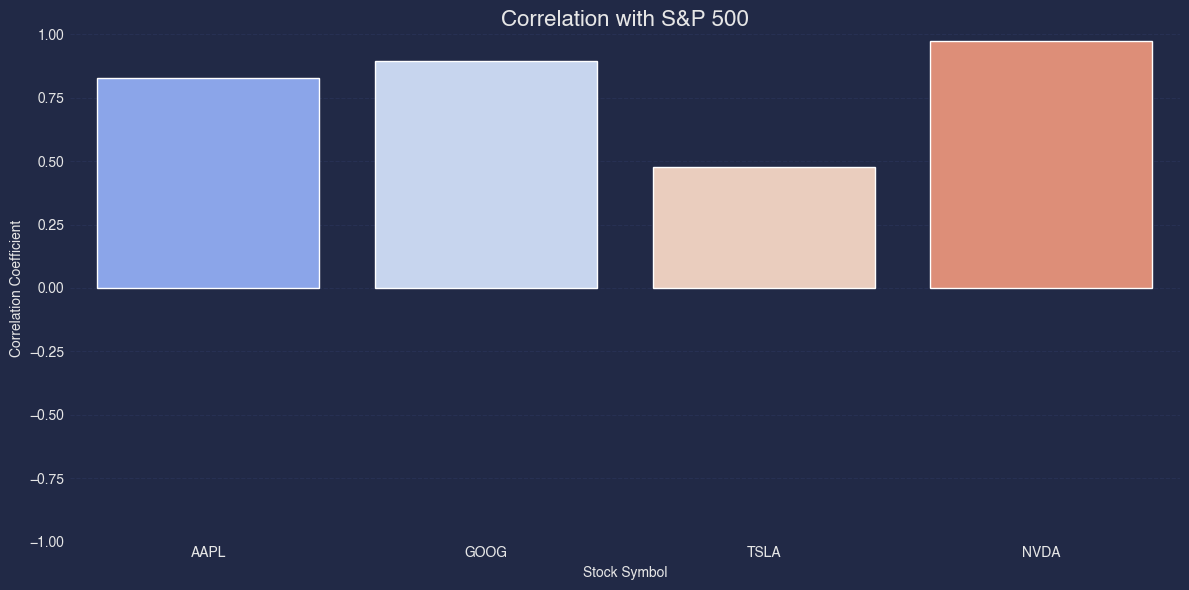

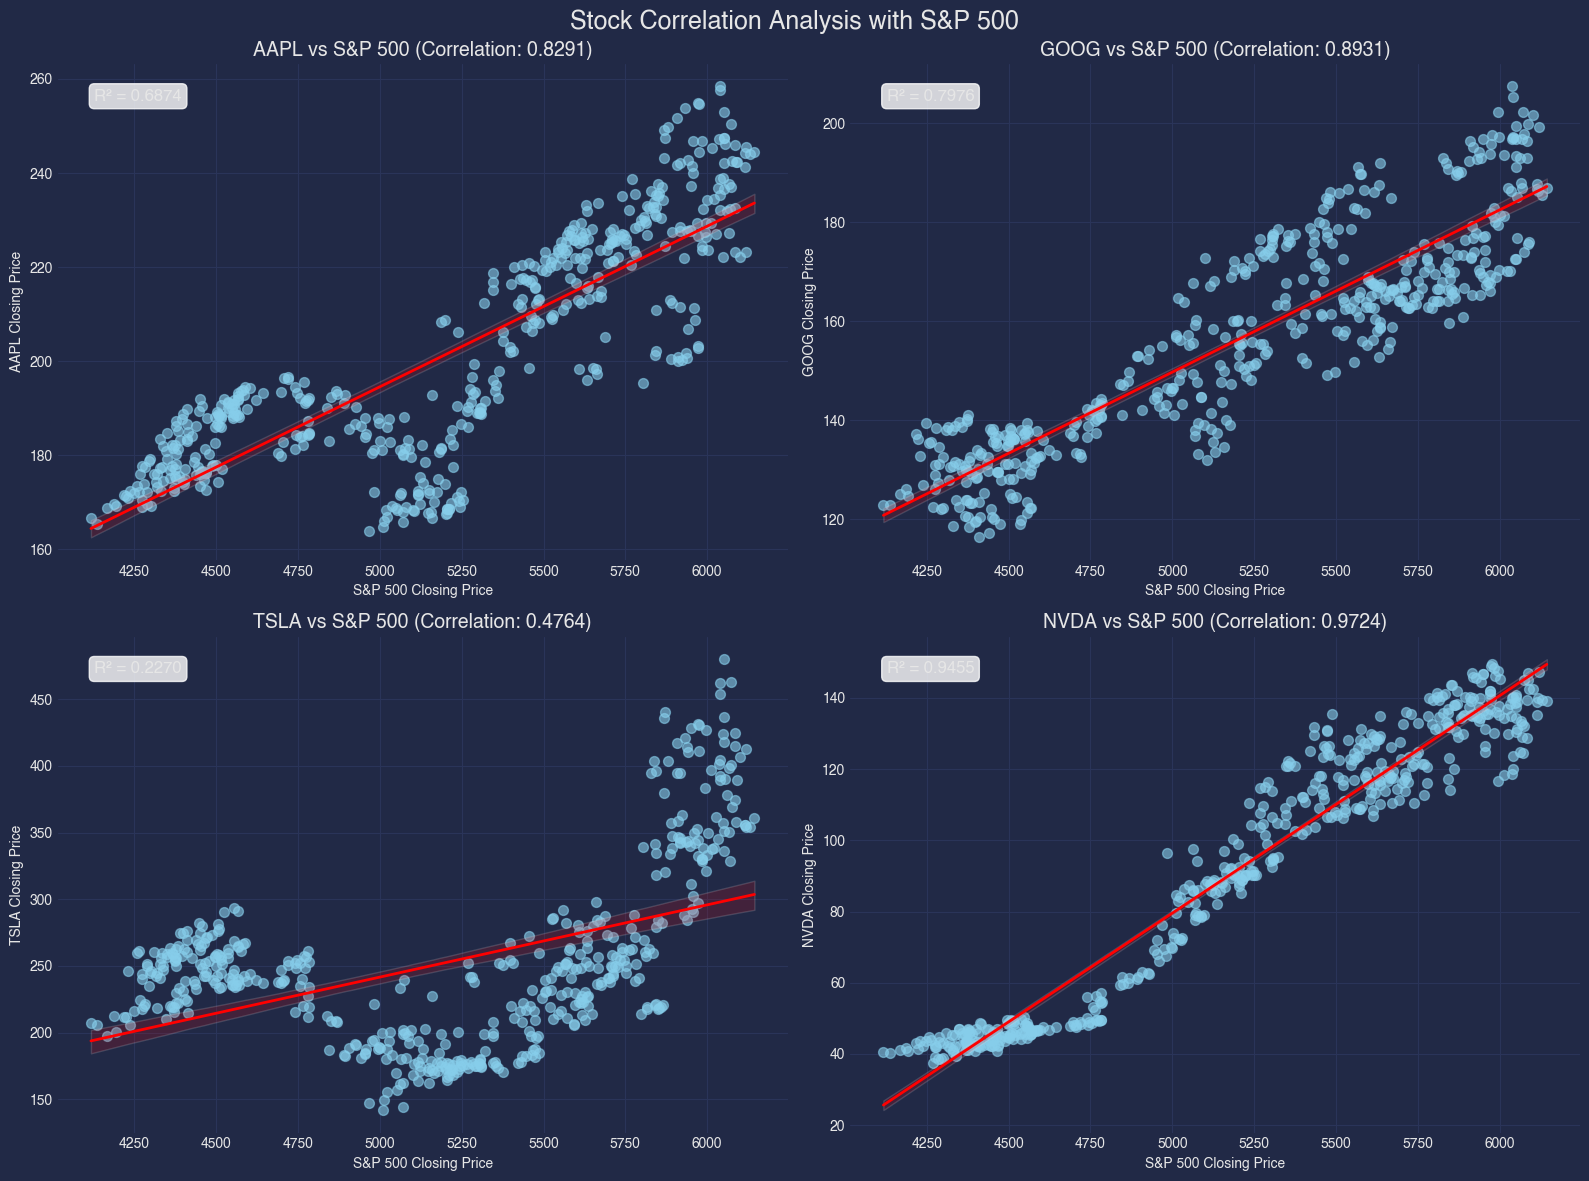

In [22]:
# Correlation Analysis with S&P 500 - Solution robuste
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import yfinance as yf

# Télécharger les données S&P 500
sp500_data = yf.download('^GSPC', start=start, end=end)['Close'].reset_index()
sp500_data.columns = ['Date', 'SP500_Close']  # Renommer explicitement

# Créer un DataFrame combiné
combined = pd.DataFrame()

for symbol, data in stock_data.items():
    # Créer une copie et simplifier les colonnes
    data = data.copy()
    data.columns = [col[0] if isinstance(col, tuple) else col for col in data.columns]
    
    # Ajouter au DataFrame combiné
    combined[symbol] = data.set_index('Date')['Close']

# Ajouter S&P 500 (en s'assurant que la date est au format datetime)
sp500_data['Date'] = pd.to_datetime(sp500_data['Date'])
combined = combined.reset_index()
combined['Date'] = pd.to_datetime(combined['Date'])
combined = pd.merge(combined, sp500_data, on='Date', how='inner').set_index('Date')

# Calculer les corrélations
correlation_df = combined.corr()['SP500_Close'].drop('SP500_Close').reset_index()
correlation_df.columns = ['Symbol', 'Correlation']
correlation_df['Company'] = correlation_df['Symbol'].map(company_names)

# Afficher les résultats
print("="*70)
print("Correlation with S&P 500:")
print("="*70)
display(correlation_df.sort_values('Correlation', ascending=False))

# Visualisation
plt.figure(figsize=(12, 6))
sns.barplot(x='Symbol', y='Correlation', data=correlation_df, palette='coolwarm')
plt.title('Correlation with S&P 500', fontsize=16)
plt.ylabel('Correlation Coefficient')
plt.xlabel('Stock Symbol')
plt.ylim(-1, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Graphiques de dispersion
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for i, symbol in enumerate(stock_symbols):
    # Calcul de la corrélation
    corr = correlation_df[correlation_df['Symbol'] == symbol]['Correlation'].values[0]
    r_squared = corr ** 2
    
    # Graphique de dispersion
    sns.regplot(
        x=combined['SP500_Close'], 
        y=combined[symbol],
        ax=axes[i],
        scatter_kws={'alpha': 0.6, 'color': 'skyblue', 's': 50},
        line_kws={'color': 'red', 'linewidth': 2}
    )
    
    axes[i].set_title(f'{symbol} vs S&P 500 (Correlation: {corr:.4f})', fontsize=14)
    axes[i].set_xlabel('S&P 500 Closing Price')
    axes[i].set_ylabel(f'{symbol} Closing Price')
    
    # Afficher R²
    axes[i].text(
        0.05, 0.95, 
        f"R² = {r_squared:.4f}",
        transform=axes[i].transAxes,
        fontsize=12,
        verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
    )

plt.suptitle('Stock Correlation Analysis with S&P 500', fontsize=18, y=0.98)
plt.tight_layout()
plt.show()

# Version interactive Plotly
fig = go.Figure()

for symbol in stock_symbols:
    fig.add_trace(go.Scatter(
        x=combined['SP500_Close'], 
        y=combined[symbol],
        mode='markers',
        name=symbol,
        marker=dict(size=8, opacity=0.7),
        hovertemplate='S&P 500: %{x:.2f}<br>Stock: %{y:.2f}<extra></extra>'
    ))

# Ajouter des lignes de régression
for symbol in stock_symbols:
    slope, intercept = np.polyfit(combined['SP500_Close'], combined[symbol], 1)
    x_range = [combined['SP500_Close'].min(), combined['SP500_Close'].max()]
    y_range = [slope * x + intercept for x in x_range]
    
    fig.add_trace(go.Scatter(
        x=x_range,
        y=y_range,
        mode='lines',
        name=f'{symbol} Trend',
        line=dict(width=2, dash='dash'),
        showlegend=False
    ))

fig.update_layout(
    title='Stock Prices vs S&P 500',
    xaxis_title='S&P 500 Closing Price',
    yaxis_title='Stock Closing Price',
    template='plotly_dark',
    height=600,
    legend_title='Stocks',
    hovermode='closest'
)

fig.show()

In [23]:
# Correlation Heatmap between Stocks
# Create a combined DataFrame of closing prices
closing_prices = pd.DataFrame()
for symbol, data in stock_data.items():
    closing_prices[symbol] = data['Close']

# Calculate correlation matrix
corr_matrix = closing_prices.corr()

In [24]:
# Create interactive correlation plot
fig = go.Figure(data=go.Heatmap(
    z=corr_matrix.values,
    x=corr_matrix.columns,
    y=corr_matrix.index,
    colorscale='RdBu',
    zmin=-1,
    zmax=1,
    text=np.round(corr_matrix.values, 2),
    texttemplate="%{text}",
    hoverongaps=False
))

fig.update_layout(
    title='Stock Correlation Matrix',
    xaxis_title='Stocks',
    yaxis_title='Stocks',
    template='plotly_dark',
    height=600
)

fig.show()

## Performance Metrics

**📑 Sharpe Ratio:**
>The Sharpe ratio is a measure that assesses the relationship between an investment's return and its risk. Introduced by economist William F. Sharpe, it compares the excess return of an investment to a benchmark with the volatility of those returns. A higher Sharpe ratio indicates better risk-adjusted performance. It helps investors understand whether historical excess returns were achieved with higher or lower volatility. The ratio's formula involves dividing the difference between returns and a benchmark by the standard deviation of returns. It's widely used for gauging risk-adjusted relative returns.
<p>&nbsp;</p>

Source: [investopedia](https://www.investopedia.com/terms/s/sharperatio.asp)

In [25]:
# Performance Metrics - Sharpe Ratio
sharpe_ratios = {}
max_drawdowns = {}
annual_returns = {}

# Risk-free rate (approximation, 10-year Treasury yield)
risk_free_rate = 0.02  # 2% annual

plt.figure(figsize=(14, 6))

for i, (symbol, data) in enumerate(stock_data.items(), 1):
    # Calculate daily returns
    daily_returns = data['Close'].pct_change().dropna()
    
    # Calculate Sharpe Ratio
    excess_returns = daily_returns - (risk_free_rate / 252)
    sharpe_ratio = np.sqrt(252) * (excess_returns.mean() / daily_returns.std())
    sharpe_ratios[symbol] = sharpe_ratio
    
    # Calculate annual return
    cumulative_return = (1 + daily_returns).prod() - 1
    annual_return = (1 + cumulative_return) ** (252/len(daily_returns)) - 1
    annual_returns[symbol] = annual_return
    
    # Calculate maximum drawdown
    cumulative = (1 + daily_returns).cumprod()
    peak = cumulative.expanding(min_periods=1).max()
    drawdown = (cumulative / peak) - 1
    max_drawdown = drawdown.min()
    max_drawdowns[symbol] = max_drawdown
    
    # Print metrics
    print(f"\nPerformance Metrics for {symbol}:")
    print(f"- Sharpe Ratio: {sharpe_ratio:.4f}")
    print(f"- Annual Return: {annual_return:.2%}")
    print(f"- Max Drawdown: {max_drawdown:.2%}")
    print(f"- Volatility: {daily_returns.std() * np.sqrt(252):.2%}")



Performance Metrics for AAPL:
- Sharpe Ratio: 0.2839
- Annual Return: 6.25%
- Max Drawdown: -33.36%
- Volatility: 27.42%

Performance Metrics for GOOG:
- Sharpe Ratio: 0.5856
- Annual Return: 16.14%
- Max Drawdown: -29.35%
- Volatility: 29.67%

Performance Metrics for TSLA:
- Sharpe Ratio: 0.4936
- Annual Return: 14.44%
- Max Drawdown: -53.77%
- Volatility: 63.58%

Performance Metrics for NVDA:
- Sharpe Ratio: 1.4519
- Annual Return: 89.59%
- Max Drawdown: -36.88%
- Volatility: 51.99%


<Figure size 1400x600 with 0 Axes>

/var/folders/0j/ljklzk2x25zff3_dbl9d8l0m0000gn/T/ipykernel_30535/3305110559.py:14: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




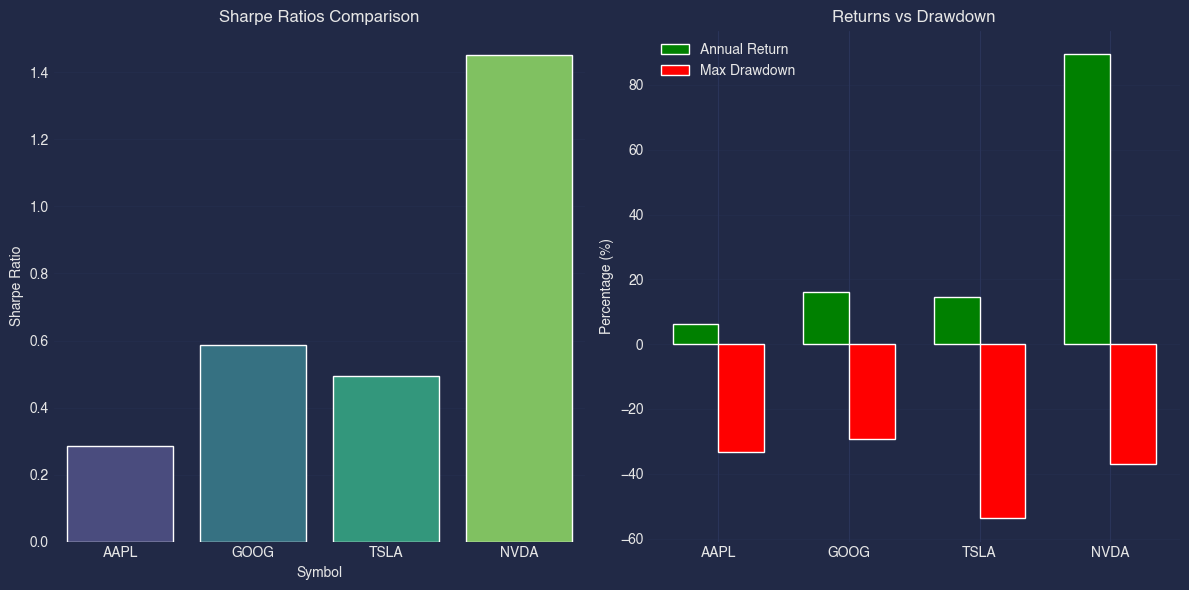

In [26]:
# Create DataFrame for metrics
metrics_df = pd.DataFrame({
    'Symbol': list(sharpe_ratios.keys()),
    'Sharpe Ratio': list(sharpe_ratios.values()),
    'Annual Return': list(annual_returns.values()),
    'Max Drawdown': list(max_drawdowns.values())
})

# Plot Sharpe Ratios
plt.figure(figsize=(12, 6))

# Bar plot for Sharpe Ratios
plt.subplot(1, 2, 1)
sns.barplot(x='Symbol', y='Sharpe Ratio', data=metrics_df, palette='viridis')
plt.title('Sharpe Ratios Comparison')
plt.ylabel('Sharpe Ratio')
plt.grid(axis='y', alpha=0.3)

# Bar plot for Annual Returns and Max Drawdown
plt.subplot(1, 2, 2)
x = np.arange(len(metrics_df))
width = 0.35

plt.bar(x - width/2, metrics_df['Annual Return'] * 100, width, label='Annual Return', color='green')
plt.bar(x + width/2, metrics_df['Max Drawdown'] * 100, width, label='Max Drawdown', color='red')

plt.title('Returns vs Drawdown')
plt.ylabel('Percentage (%)')
plt.xticks(x, metrics_df['Symbol'])
plt.legend()
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [27]:
# Create radar chart for performance comparison
metrics_normalized = metrics_df.copy()
for col in ['Sharpe Ratio', 'Annual Return', 'Max Drawdown']:
    if col == 'Max Drawdown':
        # Invert because lower is better
        metrics_normalized[col] = 1 - (metrics_df[col] - metrics_df[col].min()) / (metrics_df[col].max() - metrics_df[col].min())
    else:
        metrics_normalized[col] = (metrics_df[col] - metrics_df[col].min()) / (metrics_df[col].max() - metrics_df[col].min())

categories = metrics_normalized.columns[1:]
N = len(categories)

fig = go.Figure()

for i, row in metrics_normalized.iterrows():
    fig.add_trace(go.Scatterpolar(
        r=row[1:].tolist(),
        theta=categories,
        fill='toself',
        name=row['Symbol']
    ))

fig.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, 1]
        )),
    title='Performance Radar Chart',
    template='plotly_dark',
    height=600
)

fig.show()

# Data Preparation for Forecasting Stock Price

In [28]:
# create a new data frame with only 'Close column' using data of AAPL
aapl_close = stock_data['AAPL']['Close'].values.reshape(-1, 1)



In [29]:
# Normalize the 'AAPL_Close' column
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
aapl_close_scaled = scaler.fit_transform(aapl_close)

In [30]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 60
X, y = create_sequences(aapl_close_scaled, seq_length)

In [31]:
# Split the data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Vérifier les formes
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (354, 60, 1)
y_train shape: (354, 1)
X_test shape: (89, 60, 1)
y_test shape: (89, 1)


In [32]:
def create_dataloaders(X_train, y_train, X_test, y_test, batch_size=32):
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, test_loader

# Models Design

## Long Short-Term Memory (LSTM) 

<div>
    <p style="line-height:1.7em;">
        Long Short-Term Memory (LSTM) is a specialized type of Recurrent Neural Network (RNN) designed to address the challenge of learning long-term dependencies in sequential data. Unlike traditional RNNs, LSTMs introduce a memory cell which is a container that can hold information for a long time. Three gates control the memory cell: the input gate, the forget gate, and the output gate. These gates control the flow of information, determining what to add, remove, or output from the memory cell. This enables LSTMs to selectively retain important information over extended periods, making them effective for processing and predicting sequential data, Particularly in time series forecasting and natural language processing applications.
        <center><img src="https://media.geeksforgeeks.org/wp-content/uploads/newContent1.png" width="500" height="400"></center>
        <ol>
            <li>
                <b>Forget Gate:</b>
            </li>
            <ul>
                <li>
                    Removes outdated information from the cell state. Takes x_t and h_t-1 as inputs, processes them through weight matrices and bias, and then applies sigmoid activation.<br><p>&nbsp;</p>
                    <center><img src="https://media.geeksforgeeks.org/wp-content/uploads/newContent2.png" width="150" height="50"></center>
                </li>
            </ul>
            <br>
            <li>
                <b>Input Gate:</b>
            </li>
            <ul>
                <li>
                    Adds useful information to the cell state. Uses the sigmoid function to regulate information and filters values using the inputs h_t-1 and x_t. The tanh function is used to generate a vector.<br><p>&nbsp;</p>
                    <center><img src="https://media.geeksforgeeks.org/wp-content/uploads/newContent4.png" width="300" height="200"></center>
                </li>
            </ul>
            <li>
                <b>Output Gate:</b>
            </li>
            <ul>
                <li>
                    The purpose of this gate is to extract useful information from the current cell state for output. Uses the tanh function to generate a vector, the sigmoid function to regulate information, and the h_t-1 and x_t inputs to filter by values.<br><p>&nbsp;</p>
                  <center> <img src="https://media.geeksforgeeks.org/wp-content/uploads/newContent3.png" width="150" height="100"><br></center>
                </li>
            </ul>
        </ol>
    </p>
</div>


>*These gates allow the LSTM to manage and use information for a variety of tasks in processing sequential data. For a detailed reference, visit [geeksforgeeks]('https://www.geeksforgeeks.org/deep-learning-introduction-to-long-short-term-memory/').*

In [33]:
# Class for LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=2, output_size=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Get the last time step
        return out

## Gated Recurrent Unit (GRU)

In [34]:
# Class GRU
class GRUModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=2, output_size=1):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.gru(x)
        out = self.fc(out[:, -1, :])  # Get the last time step
        return out

## Seasonal Autoregressive Integrated Moving Average with Exogenous Regressors (SARIMAX)

In [35]:
import statsmodels.api as sm
# SARIMAX Model
def fit_sarimax(data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12), steps=30):
    model = sm.tsa.SARIMAX(data, order=order, seasonal_order=seasonal_order)
    results = model.fit()
    predictions = results.forecast(steps=steps)
    return results, predictions

# Training Models

In [36]:
# Transform the data in Loader format
train_loader, test_loader = create_dataloaders(X_train, y_train, X_test, y_test)

In [37]:
lstm_model = LSTMModel(input_size=1, hidden_size=50, num_layers=1)
gru_model = GRUModel(input_size=1, hidden_size=50, num_layers=1)
criterion = nn.MSELoss()
lstm_optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.001)
gru_optimizer = torch.optim.Adam(gru_model.parameters(), lr=0.001)
num_epochs = 50

In [38]:
# Step 1.1: Training the LSTM model
lstm_model.train()
print("Entraînement du modèle LSTM...")
for epoch in range(num_epochs):
    total_loss = 0
    for X_batch, y_batch in train_loader:
        outputs = lstm_model(X_batch)
        loss = criterion(outputs, y_batch)
        lstm_optimizer.zero_grad()
        loss.backward()
        lstm_optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    if (epoch + 1) % 10 == 0:
        print(f'LSTM Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.6f}')


Entraînement du modèle LSTM...
LSTM Epoch [10/50], Loss: 0.004797
LSTM Epoch [20/50], Loss: 0.003193
LSTM Epoch [30/50], Loss: 0.002666
LSTM Epoch [40/50], Loss: 0.002622
LSTM Epoch [50/50], Loss: 0.001920


In [39]:
# Step 1.2: Training the GRU model
gru_model.train()
print("\nEntraînement du modèle GRU...")
for epoch in range(num_epochs):
    total_loss = 0
    for X_batch, y_batch in train_loader:
        outputs = gru_model(X_batch)
        loss = criterion(outputs, y_batch)
        gru_optimizer.zero_grad()
        loss.backward()
        gru_optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    if (epoch + 1) % 10 == 0:
        print(f'GRU Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.6f}')


Entraînement du modèle GRU...
GRU Epoch [10/50], Loss: 0.002764
GRU Epoch [20/50], Loss: 0.002414
GRU Epoch [30/50], Loss: 0.001678
GRU Epoch [40/50], Loss: 0.001831
GRU Epoch [50/50], Loss: 0.001430


# Stock Price Prediction and Model Evaluation

In [40]:
# Step 2: Evaluate the models
lstm_model.eval()
gru_model.eval()
lstm_train_predictions = []
lstm_test_predictions = []
gru_train_predictions = []
gru_test_predictions = []
train_actuals = []
test_actuals = []

with torch.no_grad():
    # LSTM predictions
    print("\nPrédictions LSTM...")
    for X_batch, y_batch in train_loader:
        outputs = lstm_model(X_batch)
        lstm_train_predictions.extend(outputs.numpy())
        train_actuals.extend(y_batch.numpy())
    for X_batch, y_batch in test_loader:
        outputs = lstm_model(X_batch)
        lstm_test_predictions.extend(outputs.numpy())
        test_actuals.extend(y_batch.numpy())
    
    # GRU predictions
    print("\nPrédictions GRU...")
    for X_batch, y_batch in train_loader:
        outputs = gru_model(X_batch)
        gru_train_predictions.extend(outputs.numpy())
    for X_batch, y_batch in test_loader:
        outputs = gru_model(X_batch)
        gru_test_predictions.extend(outputs.numpy())

# Inverse transform the predictions and actuals
lstm_train_predictions = scaler.inverse_transform(np.array(lstm_train_predictions))
lstm_test_predictions = scaler.inverse_transform(np.array(lstm_test_predictions))
gru_train_predictions = scaler.inverse_transform(np.array(gru_train_predictions))
gru_test_predictions = scaler.inverse_transform(np.array(gru_test_predictions))
train_actuals = scaler.inverse_transform(np.array(train_actuals))
test_actuals = scaler.inverse_transform(np.array(test_actuals))


Prédictions LSTM...

Prédictions GRU...


In [41]:
# Step 3: Adjust and predict with SARIMAX
sarimax_model = sm.tsa.SARIMAX(stock_data['AAPL']['Close'][:train_size + seq_length], 
                               order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarimax_results = sarimax_model.fit(disp=False)
sarimax_predictions = sarimax_results.forecast(steps=len(test_actuals))

In [42]:
# Step 4: Compute RMSE
lstm_train_rmse = math.sqrt(mean_squared_error(train_actuals, lstm_train_predictions))
lstm_test_rmse = math.sqrt(mean_squared_error(test_actuals, lstm_test_predictions))
gru_train_rmse = math.sqrt(mean_squared_error(train_actuals, gru_train_predictions))
gru_test_rmse = math.sqrt(mean_squared_error(test_actuals, gru_test_predictions))
sarimax_test_rmse = math.sqrt(mean_squared_error(test_actuals, sarimax_predictions))

print(f'\nLSTM Train RMSE: {lstm_train_rmse:.2f}')
print(f'LSTM Test RMSE: {lstm_test_rmse:.2f}')
print(f'GRU Train RMSE: {gru_train_rmse:.2f}')
print(f'GRU Test RMSE: {gru_test_rmse:.2f}')
print(f'SARIMAX Test RMSE: {sarimax_test_rmse:.2f}')


LSTM Train RMSE: 4.39
LSTM Test RMSE: 8.77
GRU Train RMSE: 35.74
GRU Test RMSE: 7.58
SARIMAX Test RMSE: 35.20


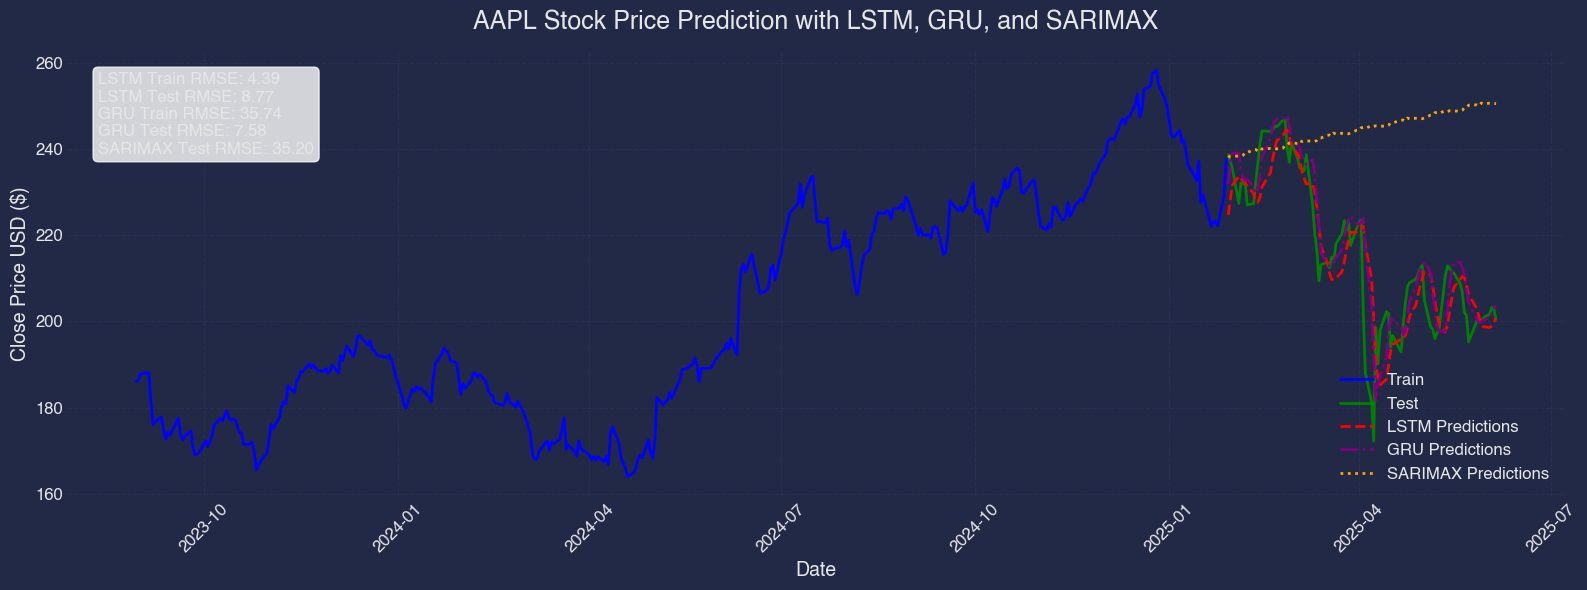

In [43]:
# Step 5: Visualisation of results
# Create a DataFrame for stock_data['AAPL'] visualisation
train_data = stock_data['AAPL'][seq_length:train_size + seq_length][['Date', 'Close']].copy().reset_index(drop=True)
test_data = stock_data['AAPL'][train_size + seq_length:][['Date', 'Close']].copy().reset_index(drop=True)

# Add predictions to the test DataFrame
test_data['LSTM_Predictions'] = lstm_test_predictions
test_data['GRU_Predictions'] = gru_test_predictions
test_data['SARIMAX_Predictions'] = sarimax_predictions.values

# Enhanced visualisation
plt.figure(figsize=(16, 6))
plt.title('AAPL Stock Price Prediction with LSTM, GRU, and SARIMAX', fontsize=18, pad=15)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Close Price USD ($)', fontsize=14)
plt.plot(train_data['Date'], train_data['Close'], label='Train', color='blue', linewidth=2)
plt.plot(test_data['Date'], test_data['Close'], label='Test', color='green', linewidth=2)
plt.plot(test_data['Date'], test_data['LSTM_Predictions'], label='LSTM Predictions', color='red', linestyle='--', linewidth=2)
plt.plot(test_data['Date'], test_data['GRU_Predictions'], label='GRU Predictions', color='purple', linestyle='-.', linewidth=2)
plt.plot(test_data['Date'], test_data['SARIMAX_Predictions'], label='SARIMAX Predictions', color='orange', linestyle=':', linewidth=2)
plt.legend(['Train', 'Test', 'LSTM Predictions', 'GRU Predictions', 'SARIMAX Predictions'], loc='lower right', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.text(0.02, 0.95, 
         f'LSTM Train RMSE: {lstm_train_rmse:.2f}\nLSTM Test RMSE: {lstm_test_rmse:.2f}\n'
         f'GRU Train RMSE: {gru_train_rmse:.2f}\nGRU Test RMSE: {gru_test_rmse:.2f}\n'
         f'SARIMAX Test RMSE: {sarimax_test_rmse:.2f}', 
         transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', 
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
plt.tight_layout()
plt.show()

In [44]:
test_data

Date       Close  LSTM_Predictions  GRU_Predictions  \
0  2025-01-29  238.783997        224.760803       231.887604   
1  2025-01-30  237.018234        228.575760       236.887726   
2  2025-01-31  235.432083        231.706558       239.154297   
3  2025-02-03  227.461304        233.757156       239.088684   
4  2025-02-04  232.239777        233.208923       235.080505   
..        ...         ...               ...              ...   
84 2025-05-30  200.850006        198.755356       200.282547   
85 2025-06-02  201.699997        198.603363       200.983154   
86 2025-06-03  203.270004        198.958633       201.844696   
87 2025-06-04  202.820007        199.827271       203.053192   
88 2025-06-05  200.630005        200.663986       203.735733   

    SARIMAX_Predictions  
0            238.128643  
1            238.454291  
2            238.475264  
3            238.386955  
4            238.416950  
..                  ...  
84           250.547698  
85           250.724589  
86           250.710553  
87           250.651308  
88           250.608928  

[89 rows x 5 columns]

**Predicted vs Actual:**
>This plot shows how the LSTM, GRU, and SARIMAX models perform against the actual stock prices of AAPL.
The LSTM and GRU models are trained on the past 60 days of data, while SARIMAX uses a more traditional time series approach.
The RMSE values indicate the accuracy of each model's predictions, with lower values indicating better performance.
The values predicted are close to the actual stock prices, demonstrating the effectiveness of these models in forecasting.

In [47]:
# Save the models

torch.save(lstm_model.state_dict(), './models/lstm_model.pth')
torch.save(gru_model.state_dict(), './models/gru_model.pth')